In [20]:
import lightgbm as lgb
import xgboost as xgb 
from sklearn.ensemble import RandomForestRegressor
import optuna.visualization as vis

import numpy as np
import optuna
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## By Country

### Data Loading

In [192]:
with open('../split_year_data/countries_dict.pkl', 'rb') as f:
    countries_dict_year = pickle.load(f)

In [203]:
filepath = '../fs_corr_income_data'

In [204]:
test_data_x60 = pd.read_csv(filepath + '/test/60/X_test.csv')
test_data_x60 = test_data_x60.drop(columns=['Unnamed: 0'], axis=1)
test_data_y60 = pd.read_csv(filepath + '/test/60/y_test.csv')
test_data_y60 = test_data_y60.drop(columns=['Unnamed: 0'], axis=1)

test_data_x70 = pd.read_csv(filepath + '/test/70/X_test.csv')
test_data_x70 = test_data_x70.drop(columns=['Unnamed: 0'], axis=1)
test_data_y70 = pd.read_csv(filepath + '/test/70/y_test.csv')
test_data_y70 = test_data_y70.drop(columns=['Unnamed: 0'], axis=1)

test_data_x80 = pd.read_csv(filepath + '/test/80/X_test.csv')
test_data_x80 = test_data_x80.drop(columns=['Unnamed: 0'], axis=1)
test_data_y80 = pd.read_csv(filepath + '/test/80/y_test.csv')
test_data_y80 = test_data_y80.drop(columns=['Unnamed: 0'], axis=1)

In [205]:
validation_60 = {}
validation_70 = {}
validation_80 = {}

for fold in range(0, 5):
    vdata_x60 = pd.read_csv(filepath + '/val/60/X_val_' + str(fold) + '.csv')
    vdata_x60 = vdata_x60.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y60 = pd.read_csv(filepath + '/val/60/y_val_' + str(fold) + '.csv')
    vdata_y60 = vdata_y60.drop(columns=['Unnamed: 0'], axis=1)
    validation_60[fold] = [vdata_x60, vdata_y60]

    vdata_x70 = pd.read_csv(filepath + '/val/70/X_val_' + str(fold) + '.csv')
    vdata_x70 = vdata_x70.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y70 = pd.read_csv(filepath + '/val/70/y_val_' + str(fold) + '.csv')
    vdata_y70 = vdata_y70.drop(columns=['Unnamed: 0'], axis=1)
    validation_70[fold] = [vdata_x70, vdata_y70]

    vdata_x80 = pd.read_csv(filepath + '/val/80/X_val_' + str(fold) + '.csv')
    vdata_x80 = vdata_x80.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y80 = pd.read_csv(filepath + '/val/80/y_val_' + str(fold) + '.csv')
    vdata_y80 = vdata_y80.drop(columns=['Unnamed: 0'], axis=1)
    validation_80[fold] = [vdata_x80, vdata_y80]

In [206]:
train_60 = {}
train_70 = {}
train_80 = {}

for corr_idx, corr in enumerate(['60', '70', '80']):
    for fold in range(0, 5):
        tdata_x85 = pd.read_csv(filepath + '/train/' + corr + '/X_train_' + str(fold) + '_85.csv')
        tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y85 = pd.read_csv(filepath + '/train/' + corr + '/y_train_' + str(fold) + '_85.csv')
        tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x90 = pd.read_csv(filepath + '/train/' + corr + '/X_train_' + str(fold) + '_90.csv')
        tdata_x90 = tdata_x90.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y90 = pd.read_csv(filepath + '/train/' + corr + '/y_train_' + str(fold) + '_90.csv')
        tdata_y90 = tdata_y90.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x95 = pd.read_csv(filepath + '/train/' + corr + '/X_train_' + str(fold) + '_95.csv')
        tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y95 = pd.read_csv(filepath + '/train/' + corr + '/y_train_' + str(fold) + '_95.csv')
        tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x1 = pd.read_csv(filepath + '/train/' + corr + '/X_train_' + str(fold) + '_1.csv')
        tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y1 = pd.read_csv(filepath + '/train/' + corr + '/y_train_' + str(fold) + '_1.csv')
        tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

        if corr_idx == 0:
            train_60[fold] = [tdata_x85, tdata_y85, tdata_x90, tdata_y90, tdata_x95, tdata_y95, tdata_x1, tdata_y1]
        if corr_idx == 1:
            train_70[fold] = [tdata_x85, tdata_y85, tdata_x90, tdata_y90, tdata_x95, tdata_y95, tdata_x1, tdata_y1]
        else: train_80[fold] = [tdata_x85, tdata_y85, tdata_x90, tdata_y90, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

In [207]:
filepath_lit = '../fs_fromlit_data'
test_data_x_lit_inc = pd.read_csv(filepath_lit + '/income/test/X_test.csv')
test_data_x_lit_inc = test_data_x_lit_inc.drop(columns=['Unnamed: 0'], axis=1)
test_data_y_lit_inc = pd.read_csv(filepath_lit + '/income/test/y_test.csv')
test_data_y_lit_inc = test_data_y_lit_inc.drop(columns=['Unnamed: 0'], axis=1)
test_data_lit_inc = pd.concat([test_data_x_lit_inc, test_data_y_lit_inc])

test_data_x_lit_year = pd.read_csv(filepath_lit + '/year/test/X_test.csv')
test_data_x_lit_year = test_data_x_lit_year.drop(columns=['Unnamed: 0'], axis=1)
test_data_y_lit_year = pd.read_csv(filepath_lit + '/year/test/y_test.csv')
test_data_y_lit_year = test_data_y_lit_year.drop(columns=['Unnamed: 0'], axis=1)
test_data_lit_year = pd.concat([test_data_x_lit_year, test_data_y_lit_year])

In [208]:
validation_lit_inc = {}
validation_lit_year = {}

for fold in range(0, 5):
    vdata_xinc = pd.read_csv(filepath_lit + '/income/val/X_val_' + str(fold) + '.csv')
    vdata_xinc = vdata_xinc.drop(columns=['Unnamed: 0'], axis=1)
    vdata_yinc = pd.read_csv(filepath_lit + '/income/val/y_val_' + str(fold) + '.csv')
    vdata_yinc = vdata_yinc.drop(columns=['Unnamed: 0'], axis=1)
    validation_lit_inc[fold] = [vdata_xinc, vdata_yinc]

    vdata_xyear = pd.read_csv(filepath_lit + '/year/val/X_val_' + str(fold) + '.csv')
    vdata_xyear = vdata_xyear.drop(columns=['Unnamed: 0'], axis=1)
    vdata_yyear = pd.read_csv(filepath_lit + '/year/val/y_val_' + str(fold) + '.csv')
    vdata_yyear = vdata_yyear.drop(columns=['Unnamed: 0'], axis=1)
    validation_lit_year[fold] = [vdata_xyear, vdata_yyear]

In [209]:
train_lit_inc = {}
train_lit_year = {}

for fold in range(0, 5):
        tdata_x85inc = pd.read_csv(filepath_lit + '/income/train/X_train_' + str(fold) + '_85.csv')
        tdata_x85inc = tdata_x85inc.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y85inc = pd.read_csv(filepath_lit + '/income/train/y_train_' + str(fold) + '_85.csv')
        tdata_y85inc = tdata_y85inc.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x90inc = pd.read_csv(filepath_lit + '/income/train/X_train_' + str(fold) + '_90.csv')
        tdata_x90inc = tdata_x90inc.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y90inc = pd.read_csv(filepath_lit + '/income/train/y_train_' + str(fold) + '_90.csv')
        tdata_y90inc = tdata_y90inc.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x95inc = pd.read_csv(filepath_lit + '/income/train/X_train_' + str(fold) + '_95.csv')
        tdata_x95inc = tdata_x95inc.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y95inc = pd.read_csv(filepath_lit + '/income/train/y_train_' + str(fold) + '_95.csv')
        tdata_y95inc = tdata_y95inc.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x1inc= pd.read_csv(filepath_lit + '/income/train/X_train_' + str(fold) + '_1.csv')
        tdata_x1inc= tdata_x1inc.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y1inc= pd.read_csv(filepath_lit + '/income/train/y_train_' + str(fold) + '_1.csv')
        tdata_y1inc= tdata_y1inc.drop(columns=['Unnamed: 0'], axis=1)

        train_lit_inc[fold] = [tdata_x85inc, tdata_y85inc, tdata_x90inc, tdata_y90inc, tdata_x95inc, tdata_y95inc, tdata_x1inc, tdata_y1inc]

        tdata_x85year = pd.read_csv(filepath_lit + '/year/train/X_train_' + str(fold) + '_85.csv')
        tdata_x85year = tdata_x85year.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y85year = pd.read_csv(filepath_lit + '/year/train/y_train_' + str(fold) + '_85.csv')
        tdata_y85year = tdata_y85year.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x90year = pd.read_csv(filepath_lit + '/year/train/X_train_' + str(fold) + '_90.csv')
        tdata_x90year = tdata_x90year.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y90year = pd.read_csv(filepath_lit + '/year/train/y_train_' + str(fold) + '_90.csv')
        tdata_y90year = tdata_y90year.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x95year = pd.read_csv(filepath_lit + '/year/train/X_train_' + str(fold) + '_95.csv')
        tdata_x95year = tdata_x95year.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y95year = pd.read_csv(filepath_lit + '/year/train/y_train_' + str(fold) + '_95.csv')
        tdata_y95year = tdata_y95year.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x1year= pd.read_csv(filepath_lit + '/year/train/X_train_' + str(fold) + '_1.csv')
        tdata_x1year= tdata_x1year.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y1year= pd.read_csv(filepath_lit + '/year/train/y_train_' + str(fold) + '_1.csv')
        tdata_y1year= tdata_y1year.drop(columns=['Unnamed: 0'], axis=1)

        train_lit_year[fold] = [tdata_x85year, tdata_y85year, tdata_x90year, tdata_y90year, tdata_x95year, tdata_y95year, tdata_x1year, tdata_y1year]

### Gathering Test Values

In [202]:
# setting up the dataframe to hold test results
index = pd.MultiIndex.from_tuples(
    [('Correlation 0.6', 'Threshold 85%', '1'), ('Correlation 0.6', 'Threshold 85%', '2'), ('Correlation 0.6', 'Threshold 85%', '3'), 
     ('Correlation 0.6', 'Threshold 85%', '4'), ('Correlation 0.6', 'Threshold 85%', '5'), ('Correlation 0.6', 'Threshold 90%', '1'), 
     ('Correlation 0.6', 'Threshold 90%', '2'), ('Correlation 0.6', 'Threshold 90%', '3'), ('Correlation 0.6', 'Threshold 90%', '4'), 
     ('Correlation 0.6', 'Threshold 90%', '5'), ('Correlation 0.6', 'Threshold 95%', '1'), 
     ('Correlation 0.6', 'Threshold 95%', '2'), ('Correlation 0.6', 'Threshold 95%', '3'), ('Correlation 0.6', 'Threshold 95%', '4'), 
     ('Correlation 0.6', 'Threshold 95%', '5'), ('Correlation 0.6', 'None', '1'), ('Correlation 0.6', 'None', '2'), 
     ('Correlation 0.6', 'None', '3'), ('Correlation 0.6', 'None', '4'), ('Correlation 0.6', 'None', '5'), 
     
     ('Correlation 0.7', 'Threshold 85%', '1'), ('Correlation 0.7', 'Threshold 85%', '2'), ('Correlation 0.7', 'Threshold 85%', '3'), 
     ('Correlation 0.7', 'Threshold 85%', '4'), ('Correlation 0.7', 'Threshold 85%', '5'), ('Correlation 0.7', 'Threshold 95%', '1'), 
     ('Correlation 0.7', 'Threshold 95%', '2'), ('Correlation 0.7', 'Threshold 95%', '3'), 
     ('Correlation 0.7', 'Threshold 95%', '4'), ('Correlation 0.7', 'Threshold 95%', '5'), ('Correlation 0.7', 'Threshold 95%', '1'), 
     ('Correlation 0.7', 'Threshold 95%', '2'), ('Correlation 0.7', 'Threshold 95%', '3'), ('Correlation 0.7', 'Threshold 95%', '4'), 
     ('Correlation 0.7', 'Threshold 95%', '5'), ('Correlation 0.7', 'None', '1'), ('Correlation 0.7', 'None', '2'), 
     ('Correlation 0.7', 'None', '3'), ('Correlation 0.7', 'None', '4'), ('Correlation 0.7', 'None', '5'), 
     
     ('Correlation 0.8', 'Threshold 85%', '1'), ('Correlation 0.8', 'Threshold 85%', '2'), ('Correlation 0.8', 'Threshold 85%', '3'), 
     ('Correlation 0.8', 'Threshold 85%', '4'), ('Correlation 0.8', 'Threshold 85%', '5'), ('Correlation 0.8', 'Threshold 95%', '1'), 
     ('Correlation 0.8', 'Threshold 95%', '2'), ('Correlation 0.8', 'Threshold 95%', '3'), 
     ('Correlation 0.8', 'Threshold 95%', '4'), ('Correlation 0.8', 'Threshold 95%', '5'), ('Correlation 0.8', 'Threshold 95%', '1'), 
     ('Correlation 0.8', 'Threshold 95%', '2'), ('Correlation 0.8', 'Threshold 95%', '3'), ('Correlation 0.8', 'Threshold 95%', '4'), 
     ('Correlation 0.8', 'Threshold 95%', '5'), ('Correlation 0.8', 'None', '1'), ('Correlation 0.8', 'None', '2'), 
     ('Correlation 0.8', 'None', '3'), ('Correlation 0.8', 'None', '4'), ('Correlation 0.8', 'None', '5'), 
     
     ('Correlation Lit', 'Threshold 85%', '1'), ('Correlation Lit', 'Threshold 85%', '2'), ('Correlation Lit', 'Threshold 85%', '3'), 
     ('Correlation Lit', 'Threshold 85%', '4'), ('Correlation Lit', 'Threshold 85%', '5'), ('Correlation Lit', 'Threshold 95%', '1'), 
     ('Correlation Lit', 'Threshold 95%', '2'), ('Correlation Lit', 'Threshold 95%', '3'), 
     ('Correlation Lit', 'Threshold 95%', '4'), ('Correlation Lit', 'Threshold 95%', '5'), ('Correlation Lit', 'Threshold 95%', '1'), 
     ('Correlation Lit', 'Threshold 95%', '2'), ('Correlation Lit', 'Threshold 95%', '3'), ('Correlation Lit', 'Threshold 95%', '4'), 
     ('Correlation Lit', 'Threshold 95%', '5'), ('Correlation Lit', 'None', '1'), ('Correlation Lit', 'None', '2'), 
     ('Correlation Lit', 'None', '3'), ('Correlation Lit', 'None', '4'), ('Correlation Lit', 'None', '5')],
    names=['Correlation Subset', 'Missing Data Threshold', 'Fold']
)
test_stats_corr_rf = pd.DataFrame(index=index, columns=['Relative Error', 'MAE', 'MSE', 'RMSE', 'R2'])
test_stats_corr_xgb = pd.DataFrame(index=index, columns=['Relative Error', 'MAE', 'MSE', 'RMSE', 'R2'])
test_stats_corr_lgb = pd.DataFrame(index=index, columns=['Relative Error', 'MAE', 'MSE', 'RMSE', 'R2'])

In [199]:
output_dir_lgb = '../feature_selection_models/by_country/lightgbm'
output_dir_lgb_lit = '../fs_fromlit_models/income/lightgbm'

In [211]:
for corr_idx, corr in enumerate(['60', '70', '80', 'lit']):
    testing_datax = None
    testing_datay = None
    training_data = None
    if corr_idx == 0:
        testing_datax = test_data_x60.copy()
        testing_datay = test_data_y60.copy()
        training_data = train_60
    elif corr_idx == 1:
        testing_datax = test_data_x70.copy()
        testing_datay = test_data_y70.copy()
        training_data = train_70
    elif corr_idx == 2:
        testing_datax = test_data_x80.copy()
        testing_datay = test_data_y80.copy()
        training_data = train_80
    elif corr_idx == 3:
        testing_datax = test_data_x_lit_inc.copy()
        testing_datay = test_data_y_lit_inc.copy()
        training_data = train_lit_inc
    
    testing_datax.columns = testing_datax.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
    testing_datay.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

    corr_name = ''
    table_corr_name = ''
    if corr_idx == 0:
        corr_name = 'corr_60'
        table_corr_name = 'Correlation 0.6'
    elif corr_idx == 1:
        corr_name = 'corr_70'
        table_corr_name = 'Correlation 0.7'
    elif corr_idx == 2: 
        corr_name = 'corr_80'
        table_corr_name = 'Correlation 0.8'
    elif corr_idx == 3: 
        table_corr_name = 'Correlation Lit'

    for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):

            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '90'
            elif thresh == 2:
                name = '95'
            else: name = '1'

            if corr_idx !=3 :
                best_params = joblib.load(f"{output_dir_lgb}/best_params_{corr_name}_{fold}_{name}.pkl")
            else:
                best_params = joblib.load(f"{output_dir_lgb_lit}/best_params_{fold}_{name}.pkl")

            train_input_data = training_data[fold][thresh * 2].copy()
            train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

            train_label = training_data[fold][thresh * 2 + 1].copy()
            train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

            to_test = testing_datax[train_input_data.columns].copy()

            loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)
            train_load = loaded_model.fit(train_input_data, train_label)
            prediction = train_load.predict(to_test)
            mse = mean_squared_error(prediction, testing_datay)
            mae = mean_absolute_error(prediction, testing_datay)
            rmse = np.sqrt(mse)
            r2 = r2_score(prediction, testing_datay)

            #to calculate re
            num_predictions = len(prediction)
            re = 0
            for p in range(0, num_predictions):
                re += np.abs(prediction[p] - testing_datay.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(testing_datay.iloc[p]))
            re = re/num_predictions

            test_stats_corr_lgb.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
            test_stats_corr_lgb.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
            test_stats_corr_lgb.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
            test_stats_corr_lgb.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
            test_stats_corr_lgb.loc[(table_corr_name, thresh_name, fold_num), 'Relative Error'] = re[0]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3061504188.py:78: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_lgb.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3061504188.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_lgb.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3061504188.py:80: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_lgb.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3061504188.py:81: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_lgb.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5

In [212]:
output_dir_xgb = '../feature_selection_models/by_country/xgboost'
output_dir_xgb_lit = '../fs_fromlit_models/income/xgboost'

In [218]:
for corr_idx, corr in enumerate(['60', '70', '80', 'lit']):
    testing_datax = None
    testing_datay = None
    training_data = None
    if corr_idx == 0:
        testing_datax = test_data_x60.copy()
        testing_datay = test_data_y60.copy()
        training_data = train_60
    elif corr_idx == 1:
        testing_datax = test_data_x70.copy()
        testing_datay = test_data_y70.copy()
        training_data = train_70
    elif corr_idx == 2:
        testing_datax = test_data_x80.copy()
        testing_datay = test_data_y80.copy()
        training_data = train_80
    elif corr_idx == 3:
        testing_datax = test_data_x_lit_inc.copy()
        testing_datay = test_data_y_lit_inc.copy()
        training_data = train_lit_inc
    
    corr_name = ''
    table_corr_name = ''
    if corr_idx == 0:
        corr_name = 'corr_60'
        table_corr_name = 'Correlation 0.6'
    elif corr_idx == 1:
        corr_name = 'corr_70'
        table_corr_name = 'Correlation 0.7'
    elif corr_idx == 2: 
        corr_name = 'corr_80'
        table_corr_name = 'Correlation 0.8'
    elif corr_idx == 3: 
        table_corr_name = 'Correlation Lit'

    for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):

            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '90'
            elif thresh == 2:
                name = '95'
            else: name = '1'

            if corr_idx !=3 :
                best_params = joblib.load(f"{output_dir_xgb}/best_params_{corr_name}_{fold}_{name}.pkl")
            else:
                best_params = joblib.load(f"{output_dir_xgb_lit}/best_params_{fold}_{name}.pkl")
                

            train_input_data = training_data[fold][thresh * 2].copy()

            train_label = training_data[fold][thresh * 2 + 1].copy()

            to_test = testing_datax[train_input_data.columns].copy()

            loaded_model = xgb.XGBRegressor(**best_params)
            train_load = loaded_model.fit(train_input_data, train_label)
            prediction = train_load.predict(to_test)
            mse = mean_squared_error(prediction, testing_datay)
            mae = mean_absolute_error(prediction, testing_datay)
            rmse = np.sqrt(mse)
            r2 = r2_score(prediction, testing_datay)

            #to calculate re
            num_predictions = len(prediction)
            re = 0
            for p in range(0, num_predictions):
                re += np.abs(prediction[p] - testing_datay.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(testing_datay.iloc[p]))
            re = re/num_predictions

            test_stats_corr_xgb.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
            test_stats_corr_xgb.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
            test_stats_corr_xgb.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
            test_stats_corr_xgb.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
            test_stats_corr_xgb.loc[(table_corr_name, thresh_name, fold_num), 'Relative Error'] = re[0]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3426273103.py:74: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_xgb.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3426273103.py:75: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_xgb.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3426273103.py:76: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_xgb.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3426273103.py:77: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_xgb.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5

In [216]:
output_dir_rf = '../feature_selection_models/by_country/rf'
output_dir_rf_lit = '../fs_fromlit_models/income/rf'

In [217]:
for corr_idx, corr in enumerate(['60', '70', '80', 'lit']):
    testing_datax = None
    testing_datay = None
    training_data = None
    if corr_idx == 0:
        testing_datax = test_data_x60.copy()
        testing_datay = test_data_y60.copy()
        training_data = train_60
    elif corr_idx == 1:
        testing_datax = test_data_x70.copy()
        testing_datay = test_data_y70.copy()
        training_data = train_70
    elif corr_idx == 2:
        testing_datax = test_data_x80.copy()
        testing_datay = test_data_y80.copy()
        training_data = train_80
    elif corr_idx == 3:
        testing_datax = test_data_x_lit_inc.copy()
        testing_datay = test_data_y_lit_inc.copy()
        training_data = train_lit_inc
    
    corr_name = ''
    table_corr_name = ''
    if corr_idx == 0:
        corr_name = 'corr_60'
        table_corr_name = 'Correlation 0.6'
    elif corr_idx == 1:
        corr_name = 'corr_70'
        table_corr_name = 'Correlation 0.7'
    elif corr_idx == 2: 
        corr_name = 'corr_80'
        table_corr_name = 'Correlation 0.8'
    elif corr_idx == 3: 
        table_corr_name = 'Correlation Lit'

    for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):

            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '90'
            elif thresh == 2:
                name = '95'
            else: name = '1'

            if corr_idx != 3:
                best_params = joblib.load(f"{output_dir_rf}/best_params_{corr_name}_{fold}_{name}.pkl")
            else:
                best_params = joblib.load(f"{output_dir_rf_lit}/best_params_{fold}_{name}.pkl")

            train_input_data = training_data[fold][thresh * 2].copy()

            train_label = training_data[fold][thresh * 2 + 1].copy()

            to_test = testing_datax[train_input_data.columns].copy()

            loaded_model = RandomForestRegressor(**best_params)
            train_load = loaded_model.fit(train_input_data, train_label)
            prediction = train_load.predict(to_test)
            mse = mean_squared_error(prediction, testing_datay)
            mae = mean_absolute_error(prediction, testing_datay)
            rmse = np.sqrt(mse)
            r2 = r2_score(prediction, testing_datay)

            #to calculate re
            num_predictions = len(prediction)
            re = 0
            for p in range(0, num_predictions):
                re += np.abs(prediction[p] - testing_datay.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(testing_datay.iloc[p]))
            re = re/num_predictions

            test_stats_corr_rf.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
            test_stats_corr_rf.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
            test_stats_corr_rf.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
            test_stats_corr_rf.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
            test_stats_corr_rf.loc[(table_corr_name, thresh_name, fold_num), 'Relative Error'] = re[0]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1666577800.py:73: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_rf.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1666577800.py:74: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_rf.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1666577800.py:75: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_rf.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
/var/folders/jd/0gmk2m5x1cl

In [219]:
mean_summary_lgb = test_stats_corr_lgb.groupby(['Correlation Subset', 'Missing Data Threshold']).mean()
mean_summary_lgb = mean_summary_lgb.astype('float')
mean_summary_lgb = mean_summary_lgb.round(2)
std_summary_lgb = test_stats_corr_lgb.groupby(['Correlation Subset', 'Missing Data Threshold']).std()
std_summary_lgb = std_summary_lgb.astype('float')
std_summary_lgb = std_summary_lgb.round(2)

In [220]:
mean_summary_xgb = test_stats_corr_xgb.groupby(['Correlation Subset', 'Missing Data Threshold']).mean()
mean_summary_xgb = mean_summary_xgb.astype('float')
mean_summary_xgb = mean_summary_xgb.round(2)
std_summary_xgb = test_stats_corr_xgb.groupby(['Correlation Subset', 'Missing Data Threshold']).std()
std_summary_xgb = std_summary_xgb.astype('float')
std_summary_xgb = std_summary_xgb.round(2)

In [221]:
mean_summary_rf = test_stats_corr_rf.groupby(['Correlation Subset', 'Missing Data Threshold']).mean()
mean_summary_rf = mean_summary_rf.astype('float')
mean_summary_rf = mean_summary_rf.round(2)
std_summary_rf = test_stats_corr_rf.groupby(['Correlation Subset', 'Missing Data Threshold']).std()
std_summary_rf = std_summary_rf.astype('float')
std_summary_rf = std_summary_rf.round(2)

### Visualisation

#### Gathering Comparison Benchmark

In [246]:
mean_original = joblib.load('../split_income_models/base_mean_metrics.pkl')
std_original = joblib.load('../split_income_models/base_std_metrics.pkl')

In [293]:
no_corr_df_lgb = mean_original['LightGBM']
no_corr_df_lgb['Correlation Subset'] = 'No Feature Selection'
no_corr_df_lgb.set_index('Correlation Subset', append=True, inplace=True)
no_corr_df_lgb = no_corr_df_lgb.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_data_lgb = pd.concat([mean_summary_lgb, no_corr_df_lgb])

no_corr_std_lgb = std_original['LightGBM']
no_corr_std_lgb['Correlation Subset'] = 'No Feature Selection'
no_corr_std_lgb.set_index('Correlation Subset', append=True, inplace=True)
no_corr_std_lgb = no_corr_std_lgb.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_std_data_lgb = pd.concat([std_summary_lgb, no_corr_std_lgb])

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/818620845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_df_lgb['Correlation Subset'] = 'No Feature Selection'
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/818620845.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_std_lgb['Correlation Subset'] = 'No Feature Selection'


In [331]:
no_corr_df_xgb = mean_original['XGBoost']
no_corr_df_xgb['Correlation Subset'] = 'No Feature Selection'
no_corr_df_xgb.set_index('Correlation Subset', append=True, inplace=True)
no_corr_df_xgb = no_corr_df_xgb.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_data_xgb = pd.concat([mean_summary_xgb, no_corr_df_xgb])

no_corr_std_xgb = std_original['XGBoost']
no_corr_std_xgb['Correlation Subset'] = 'No Feature Selection'
no_corr_std_xgb.set_index('Correlation Subset', append=True, inplace=True)
no_corr_std_xgb = no_corr_std_xgb.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_std_data_xgb = pd.concat([std_summary_xgb, no_corr_std_xgb])

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3627205704.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_df_xgb['Correlation Subset'] = 'No Feature Selection'
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3627205704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_std_xgb['Correlation Subset'] = 'No Feature Selection'


In [291]:
no_corr_df_rf = mean_original['Random Forest']
no_corr_df_rf['Correlation Subset'] = 'No Feature Selection'
no_corr_df_rf.set_index('Correlation Subset', append=True, inplace=True)
no_corr_df_rf = no_corr_df_rf.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_data_rf = pd.concat([mean_summary_rf, no_corr_df_rf])

no_corr_std_rf = std_original['Random Forest']
no_corr_std_rf['Correlation Subset'] = 'No Feature Selection'
no_corr_std_rf.set_index('Correlation Subset', append=True, inplace=True)
no_corr_std_rf = no_corr_std_rf.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_std_data_rf = pd.concat([std_summary_rf, no_corr_std_rf])

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/4089201430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_df_rf['Correlation Subset'] = 'No Feature Selection'
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/4089201430.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_std_rf['Correlation Subset'] = 'No Feature Selection'


#### Plotting

#### LightGBM

In [322]:
mean_data_lgb = all_data_lgb.astype(float)
std_data_lgb = all_std_data_lgb.astype(float)

new_order = ['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']
mean_data_lgb = all_data_lgb.astype(float)
std_data_lgb = all_std_data_lgb.astype(float)

mean_data_lgb.index = mean_data_lgb.index.set_levels(
    [mean_data_lgb.index.levels[0], pd.CategoricalIndex(mean_data_lgb.index.levels[1], categories=new_order, ordered=True)]
)

mean_data_lgb = mean_data_lgb.sort_index()

std_data_lgb.index = std_data_lgb.index.set_levels(
    [std_data_lgb.index.levels[0], pd.CategoricalIndex(std_data_lgb.index.levels[1], categories=new_order, ordered=True)]
)

std_data_lgb = std_data_lgb.sort_index()

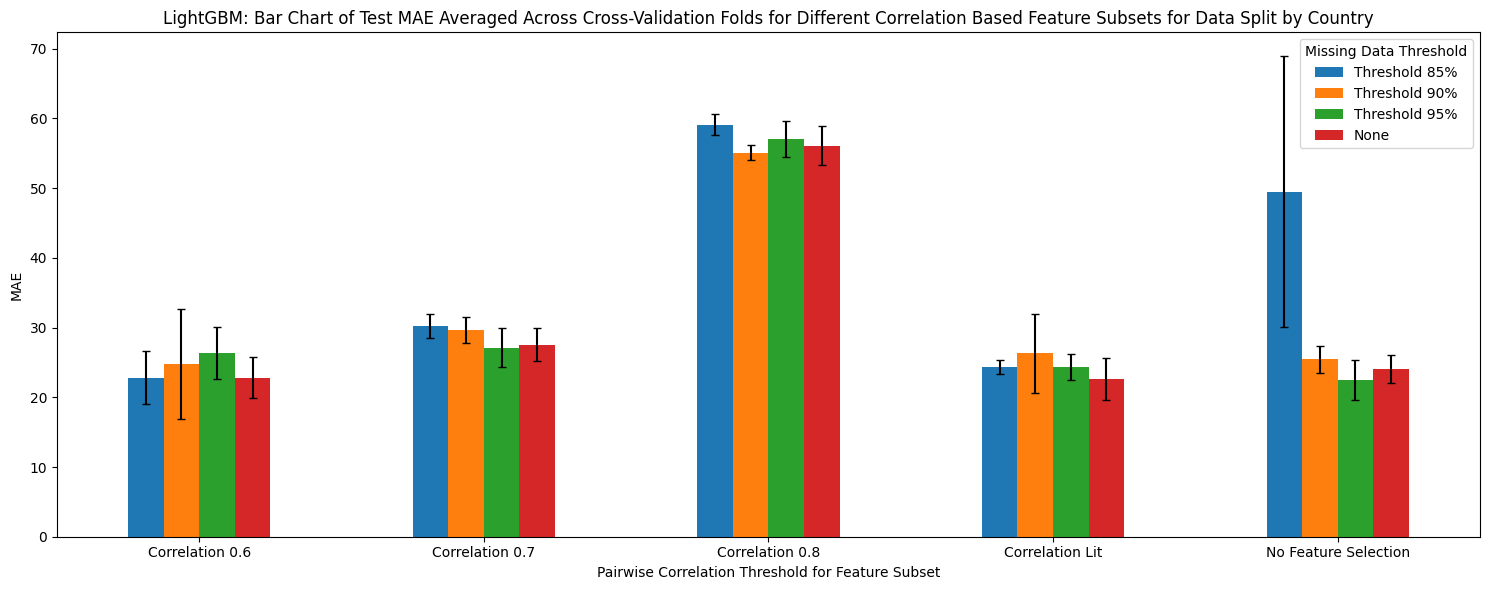

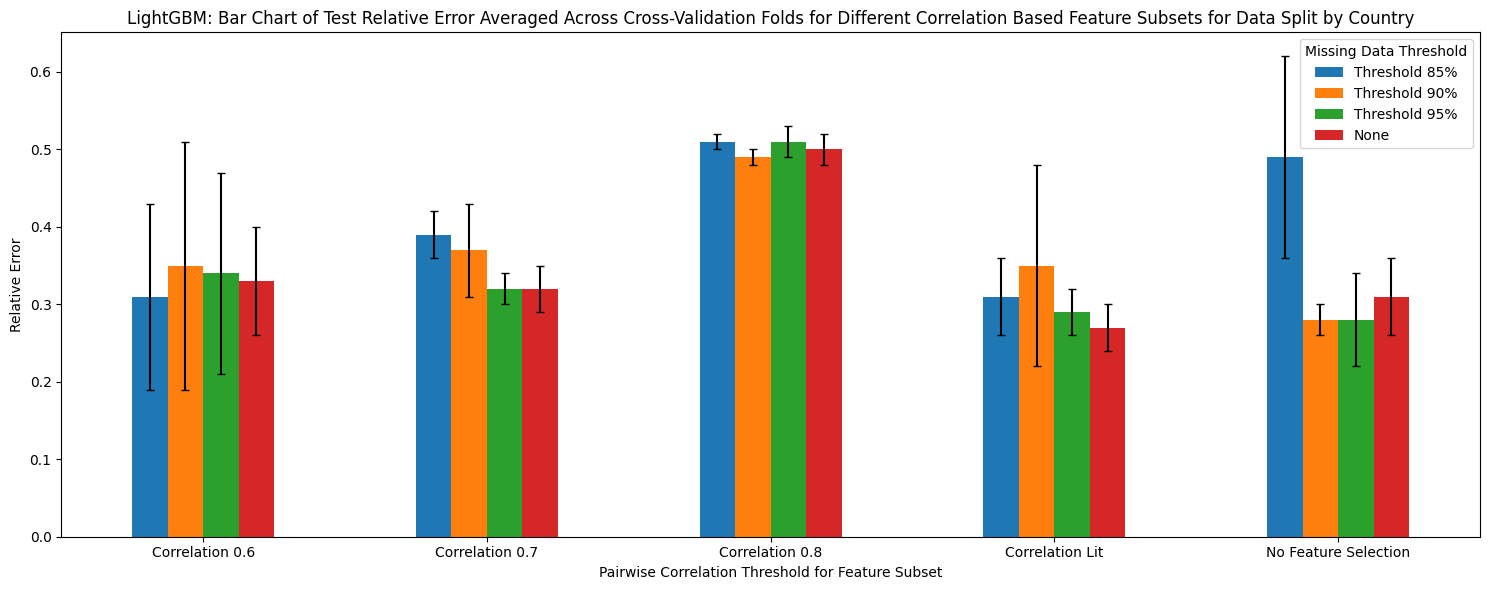

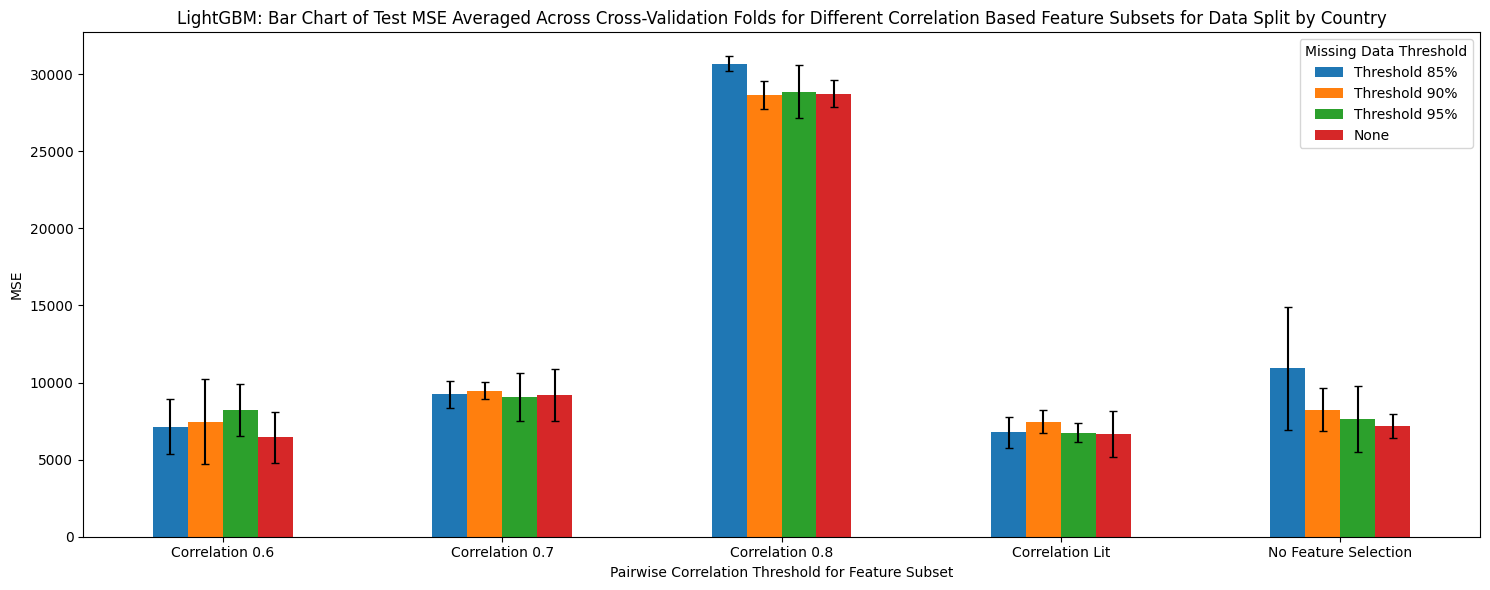

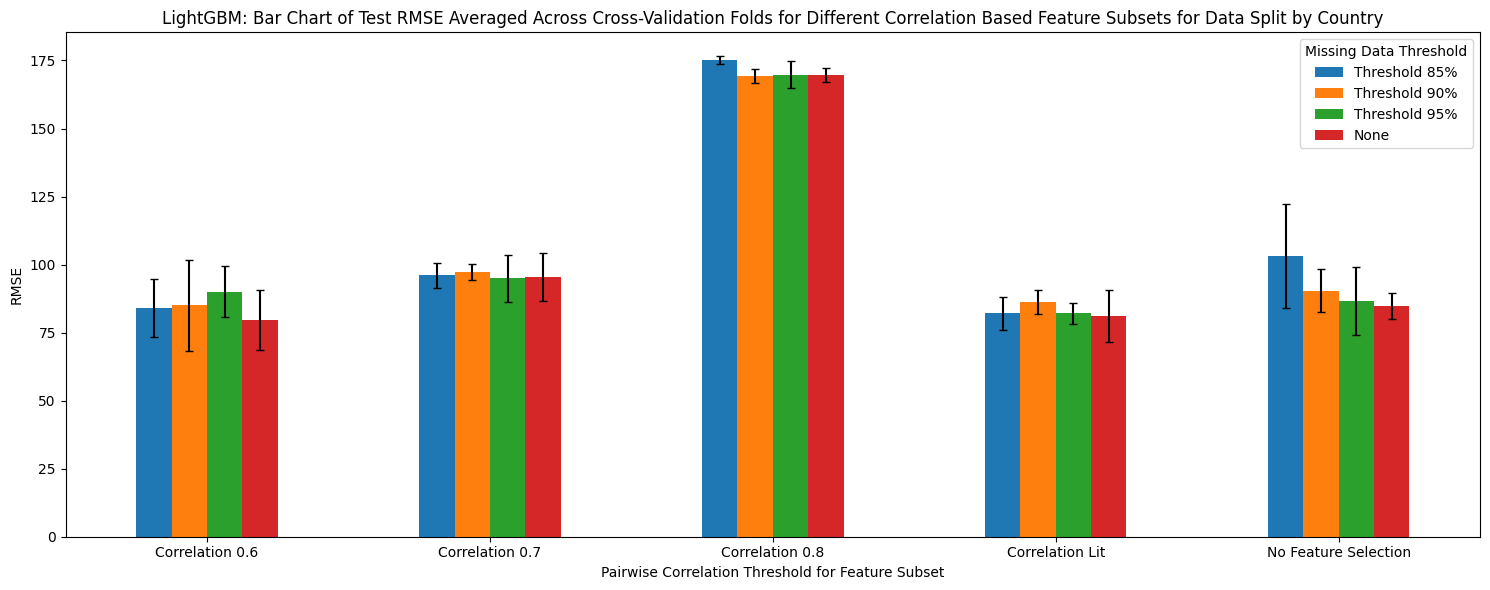

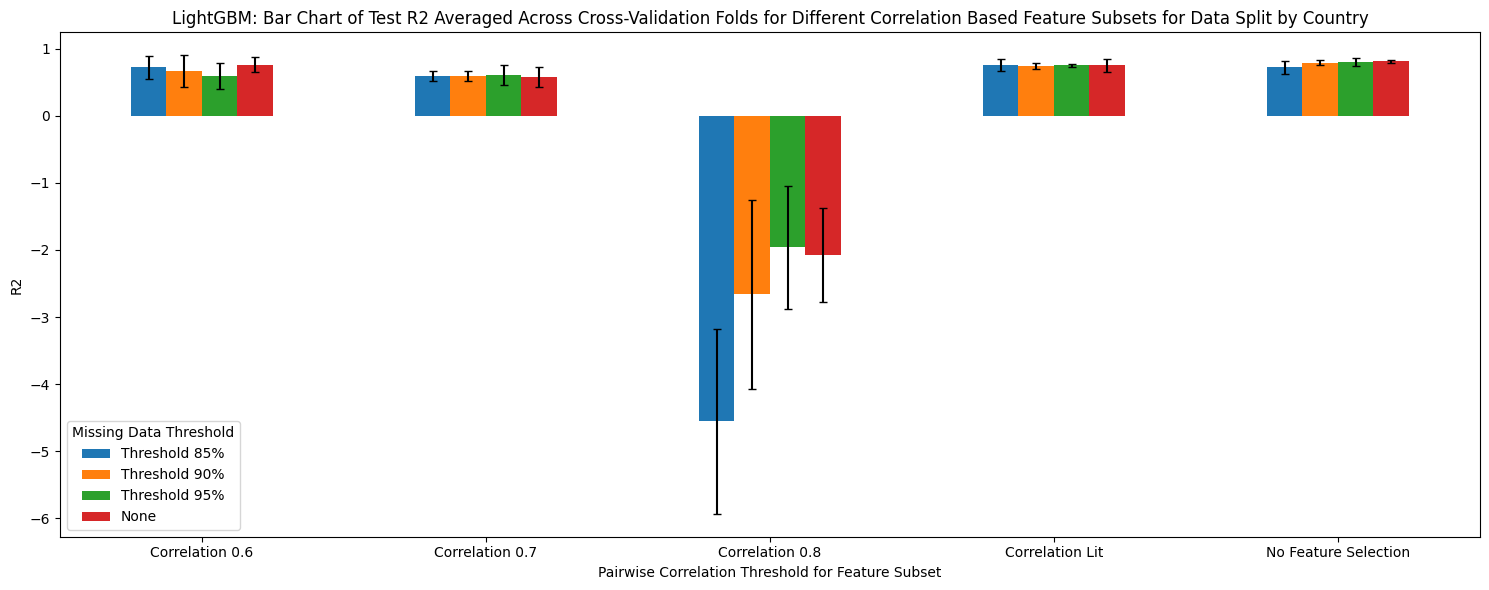

In [323]:
for metric in ['MAE', 'Relative Error', 'MSE', 'RMSE', 'R2']:
    mean_vals = mean_data_lgb[metric].unstack(level='Missing Data Threshold')
    std_vals = std_data_lgb[metric].unstack(level='Missing Data Threshold')
    mean_vals.plot.bar(yerr=std_vals, figsize=(15, 6), rot=0, capsize=3)
    plt.title("LightGBM: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds for Different Correlation Based Feature Subsets for Data Split by Country")
    plt.xlabel("Pairwise Correlation Threshold for Feature Subset")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

#### XGB

In [332]:
new_order = ['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']
mean_data_xgb = all_data_xgb.astype(float)
std_data_xgb = all_std_data_xgb.astype(float)

mean_data_xgb.index = mean_data_xgb.index.set_levels(
    [mean_data_xgb.index.levels[0], pd.CategoricalIndex(mean_data_xgb.index.levels[1], categories=new_order, ordered=True)]
)

mean_data_xgb = mean_data_xgb.sort_index()

std_data_xgb.index = std_data_xgb.index.set_levels(
    [std_data_xgb.index.levels[0], pd.CategoricalIndex(std_data_xgb.index.levels[1], categories=new_order, ordered=True)]
)

std_data_xgb = std_data_xgb.sort_index()

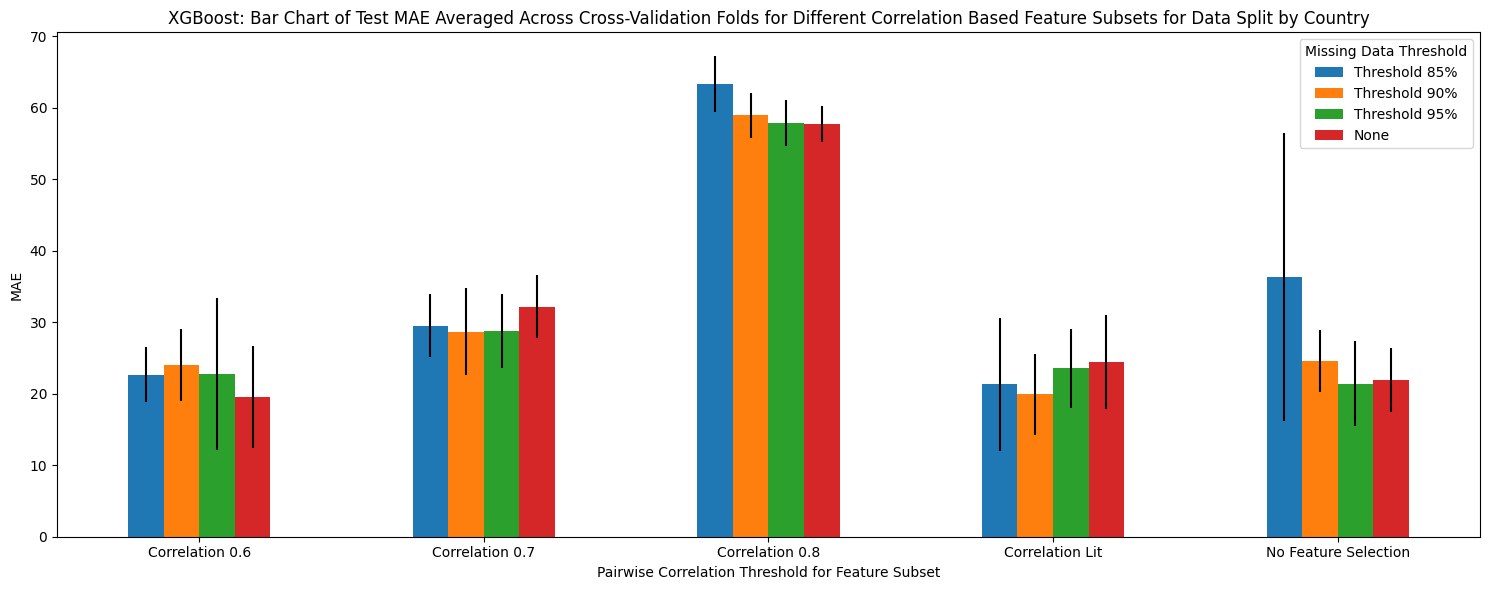

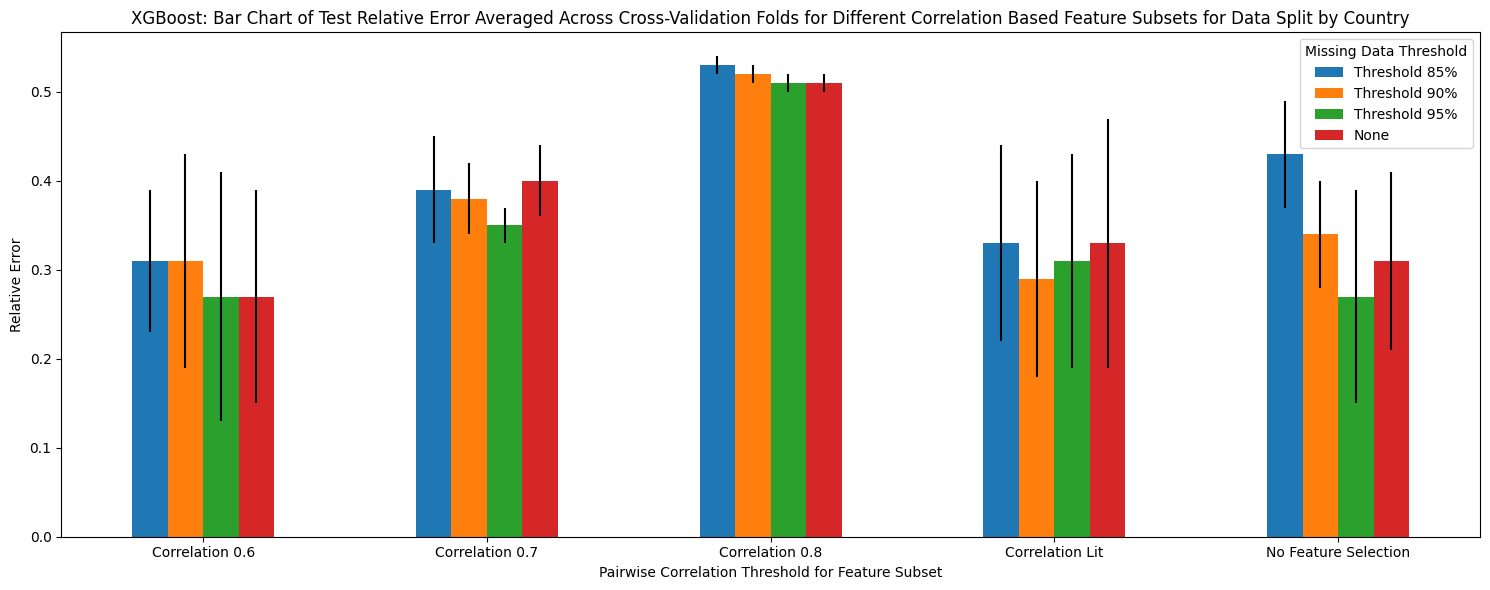

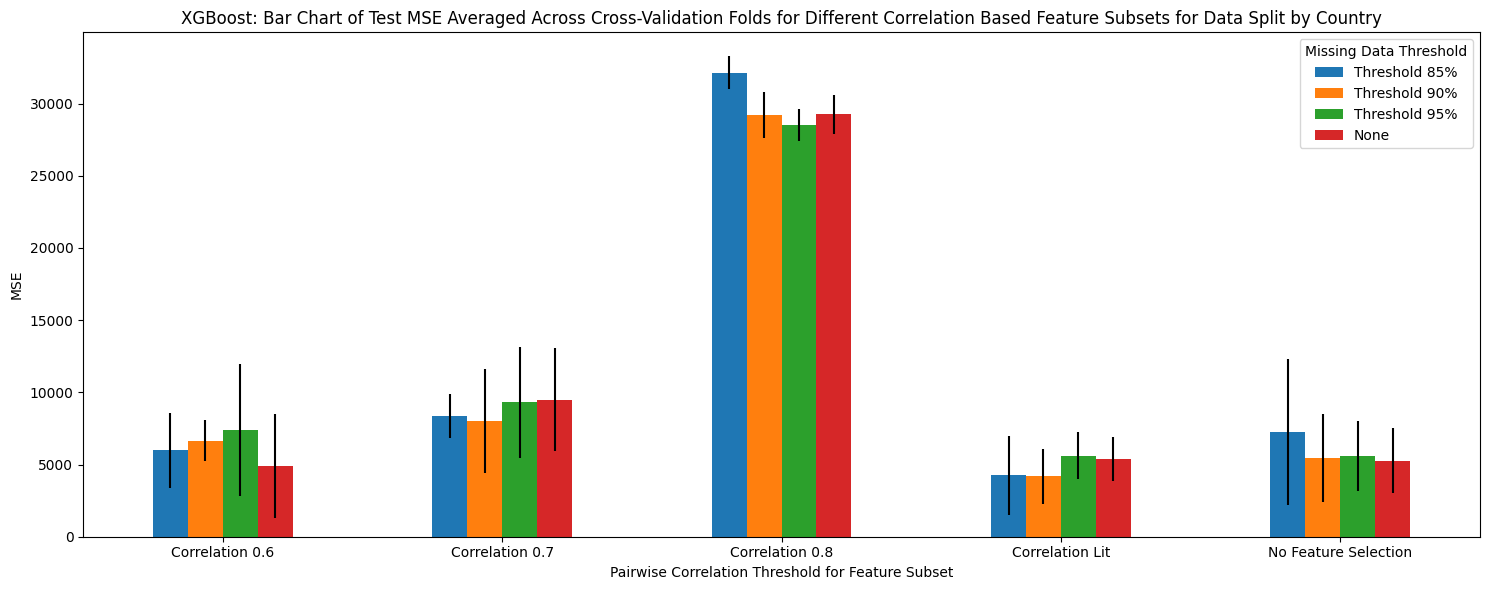

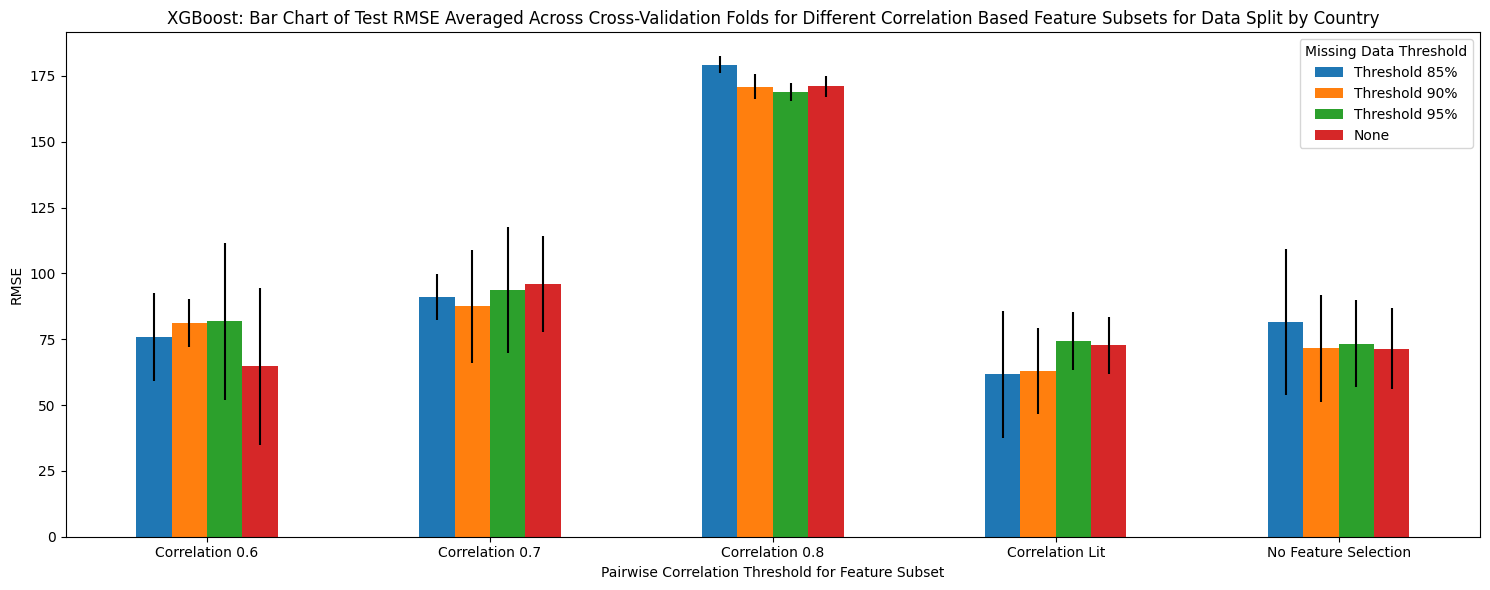

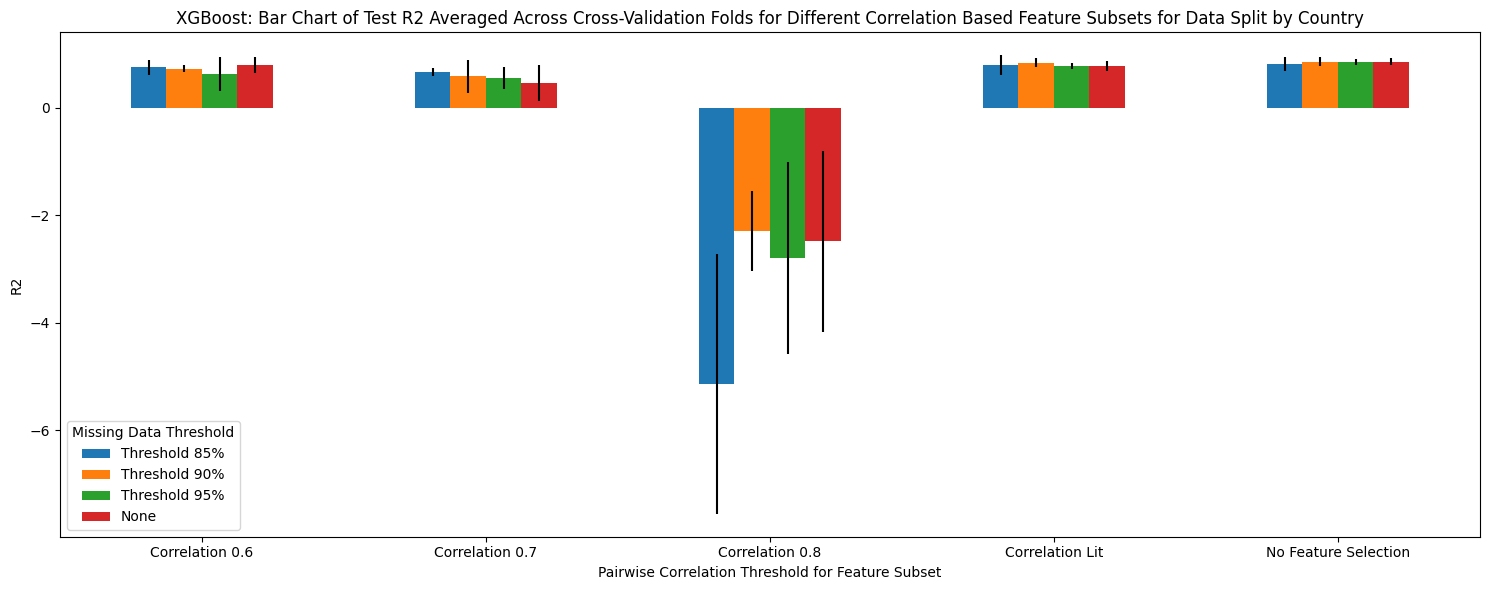

In [333]:
for metric in ['MAE', 'Relative Error', 'MSE', 'RMSE', 'R2']:
    mean_vals = mean_data_xgb[metric].unstack(level='Missing Data Threshold')
    std_vals = std_data_xgb[metric].unstack(level='Missing Data Threshold')
    mean_vals.plot.bar(yerr=std_vals, figsize=(15, 6), rot=0)
    plt.title("XGBoost: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds for Different Correlation Based Feature Subsets for Data Split by Country")
    plt.xlabel("Pairwise Correlation Threshold for Feature Subset")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

#### RF

In [319]:
mean_data_rf = all_data_rf.astype(float)
std_data_rf = all_std_data_rf.astype(float)

new_order = ['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']
mean_data_rf = all_data_rf.astype(float)
std_data_rf = all_std_data_rf.astype(float)

mean_data_rf.index = mean_data_rf.index.set_levels(
    [mean_data_rf.index.levels[0], pd.CategoricalIndex(mean_data_rf.index.levels[1], categories=new_order, ordered=True)]
)

mean_data_rf = mean_data_rf.sort_index()

std_data_rf.index = std_data_rf.index.set_levels(
    [std_data_rf.index.levels[0], pd.CategoricalIndex(std_data_rf.index.levels[1], categories=new_order, ordered=True)]
)

std_data_rf = std_data_rf.sort_index()

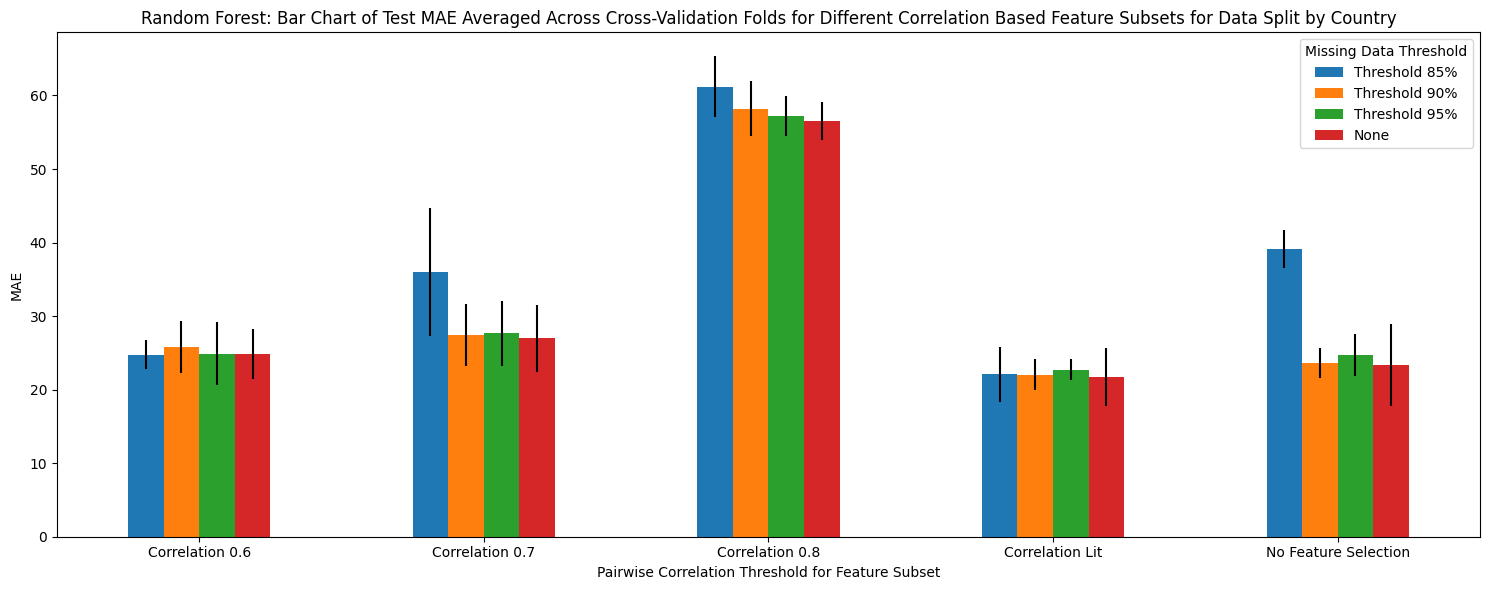

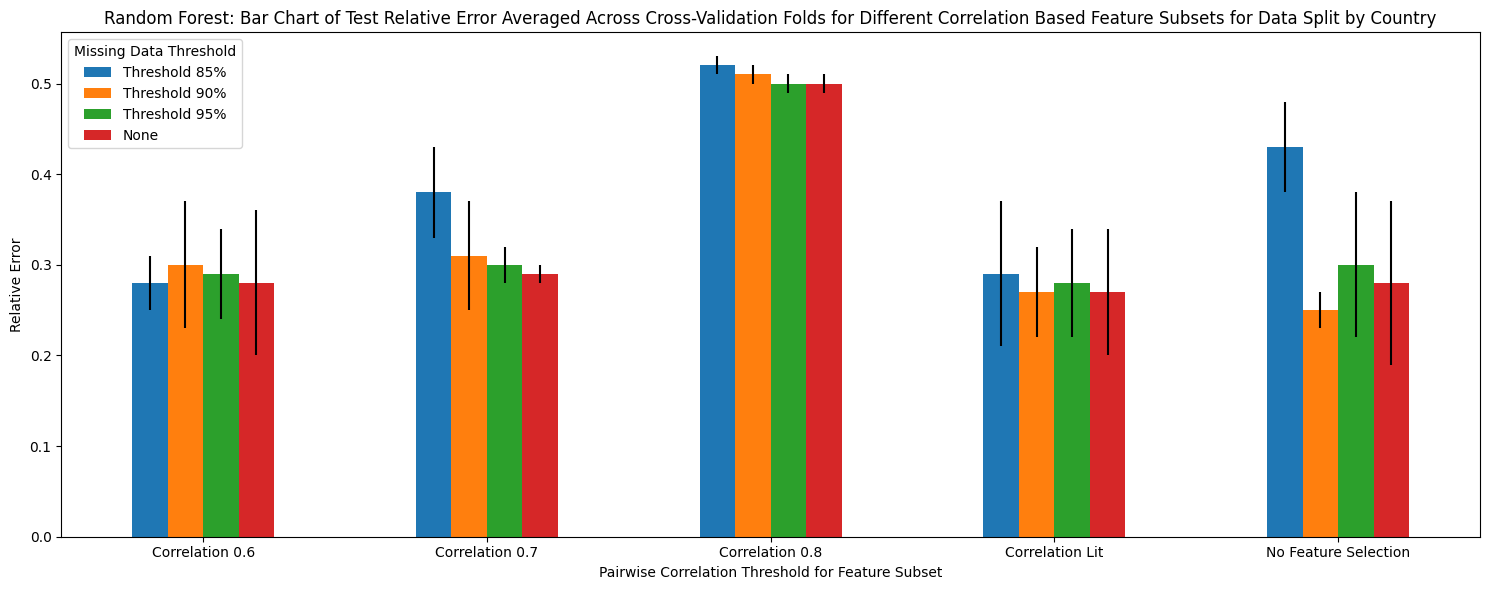

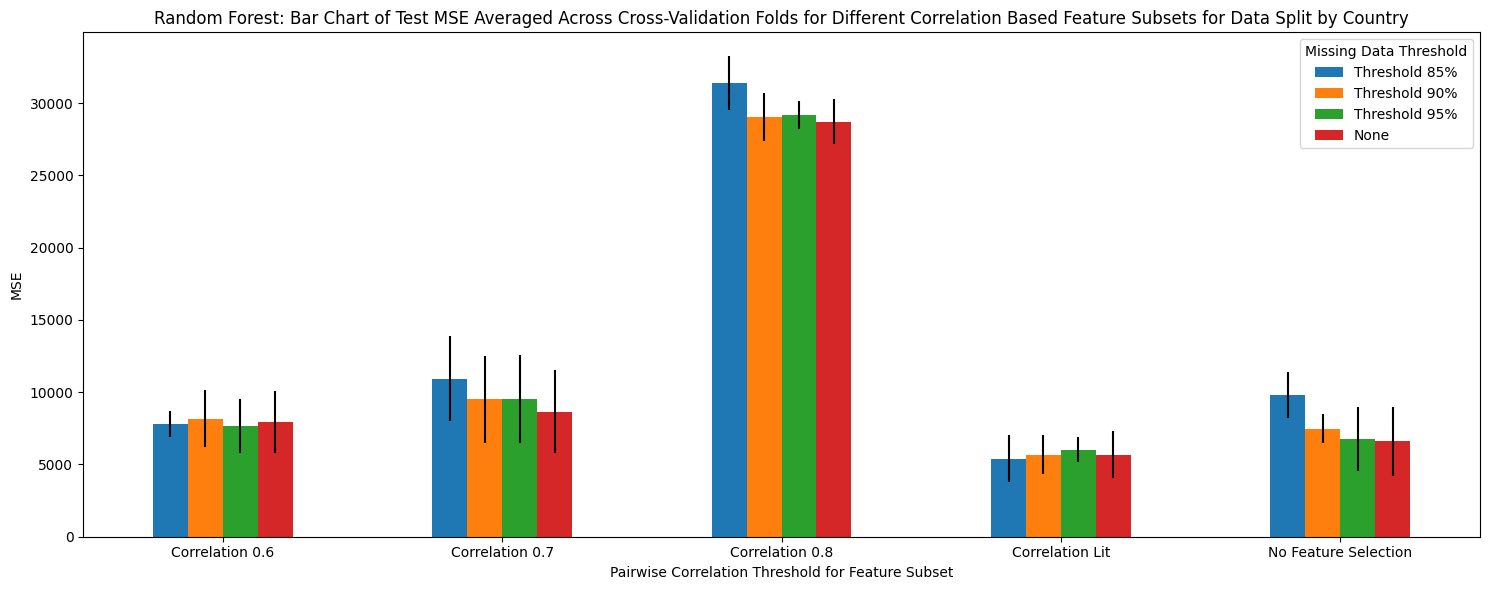

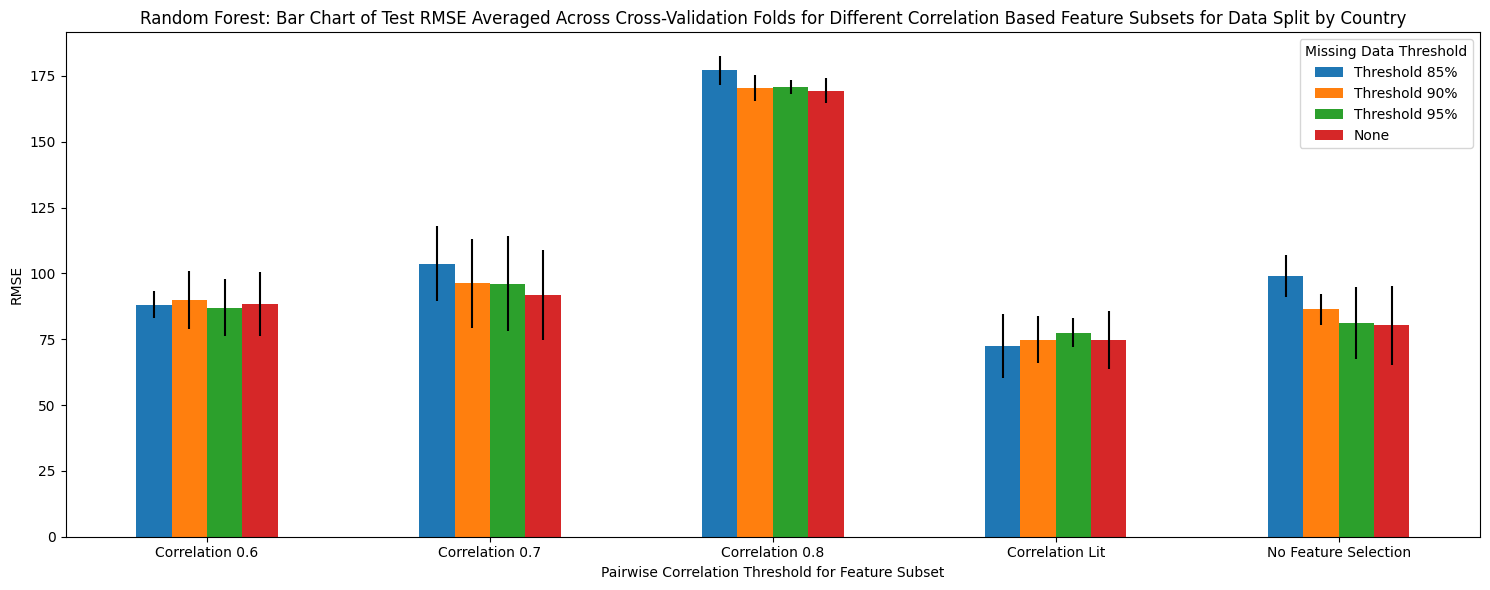

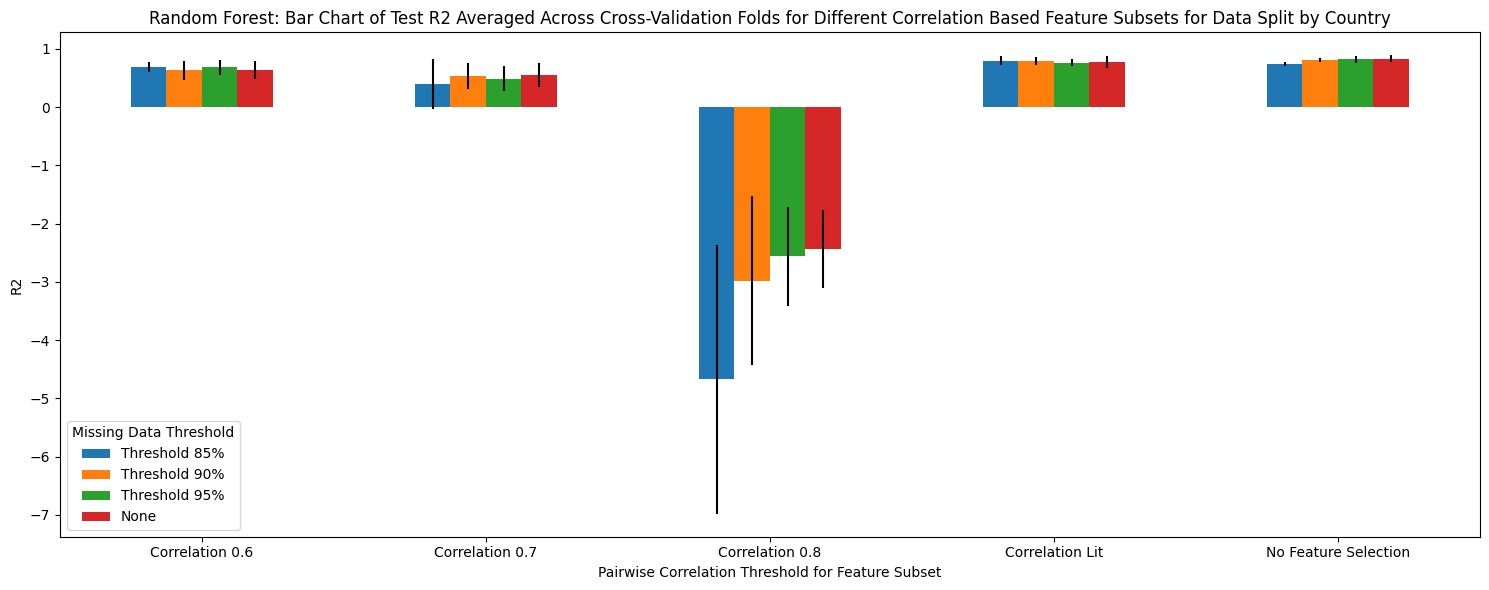

In [321]:
for metric in ['MAE', 'Relative Error', 'MSE', 'RMSE', 'R2']:
    mean_vals = mean_data_rf[metric].unstack(level='Missing Data Threshold')
    std_vals = std_data_rf[metric].unstack(level='Missing Data Threshold')
    mean_vals.plot.bar(yerr=std_vals, figsize=(15, 6), rot=0)
    plt.title("Random Forest: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds for Different Correlation Based Feature Subsets for Data Split by Country")
    plt.xlabel("Pairwise Correlation Threshold for Feature Subset")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

## By Year

### Loading Data

In [231]:
filepath_year = '../fs_corr_year_data'

In [232]:
test_data_x60_year = pd.read_csv(filepath_year + '/test/60/X_test.csv')
test_data_x60_year = test_data_x60_year.drop(columns=['Unnamed: 0'], axis=1)
test_data_y60_year = pd.read_csv(filepath_year + '/test/60/y_test.csv')
test_data_y60_year = test_data_y60_year.drop(columns=['Unnamed: 0'], axis=1)

test_data_x70_year = pd.read_csv(filepath_year + '/test/70/X_test.csv')
test_data_x70_year = test_data_x70_year.drop(columns=['Unnamed: 0'], axis=1)
test_data_y70_year = pd.read_csv(filepath_year + '/test/70/y_test.csv')
test_data_y70_year = test_data_y70_year.drop(columns=['Unnamed: 0'], axis=1)

test_data_x80_year = pd.read_csv(filepath_year + '/test/80/X_test.csv')
test_data_x80_year = test_data_x80_year.drop(columns=['Unnamed: 0'], axis=1)
test_data_y80_year = pd.read_csv(filepath_year + '/test/80/y_test.csv')
test_data_y80_year = test_data_y80_year.drop(columns=['Unnamed: 0'], axis=1)

In [233]:
validation_60_year = {}
validation_70_year = {}
validation_80_year = {}

for fold in range(0, 5):
    vdata_x60_year = pd.read_csv(filepath_year + '/val/60/X_val_' + str(fold) + '.csv')
    vdata_x60_year = vdata_x60_year.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y60_year = pd.read_csv(filepath_year + '/val/60/y_val_' + str(fold) + '.csv')
    vdata_y60_year = vdata_y60_year.drop(columns=['Unnamed: 0'], axis=1)
    validation_60_year[fold] = [vdata_x60_year, vdata_y60_year]

    vdata_x70_year = pd.read_csv(filepath_year + '/val/70/X_val_' + str(fold) + '.csv')
    vdata_x70_year = vdata_x70_year.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y70_year = pd.read_csv(filepath_year + '/val/70/y_val_' + str(fold) + '.csv')
    vdata_y70_year = vdata_y70_year.drop(columns=['Unnamed: 0'], axis=1)
    validation_70_year[fold] = [vdata_x70_year, vdata_y70_year]

    vdata_x80_year = pd.read_csv(filepath_year + '/val/80/X_val_' + str(fold) + '.csv')
    vdata_x80_year = vdata_x80_year.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y80_year = pd.read_csv(filepath_year + '/val/80/y_val_' + str(fold) + '.csv')
    vdata_y80_year = vdata_y80_year.drop(columns=['Unnamed: 0'], axis=1)
    validation_80_year[fold] = [vdata_x80_year, vdata_y80_year]

In [234]:
train_60_year = {}
train_70_year = {}
train_80_year = {}

for corr_idx, corr in enumerate(['60', '70', '80']):
    for fold in range(0, 5):
        tdata_x85 = pd.read_csv(filepath_year + '/train/' + corr + '/X_train_' + str(fold) + '_85.csv')
        tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y85 = pd.read_csv(filepath_year + '/train/' + corr + '/y_train_' + str(fold) + '_85.csv')
        tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x90 = pd.read_csv(filepath_year + '/train/' + corr + '/X_train_' + str(fold) + '_90.csv')
        tdata_x90 = tdata_x90.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y90 = pd.read_csv(filepath_year + '/train/' + corr + '/y_train_' + str(fold) + '_90.csv')
        tdata_y90 = tdata_y90.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x95 = pd.read_csv(filepath_year + '/train/' + corr + '/X_train_' + str(fold) + '_95.csv')
        tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y95 = pd.read_csv(filepath_year + '/train/' + corr + '/y_train_' + str(fold) + '_95.csv')
        tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x1 = pd.read_csv(filepath_year + '/train/' + corr + '/X_train_' + str(fold) + '_1.csv')
        tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y1 = pd.read_csv(filepath_year + '/train/' + corr + '/y_train_' + str(fold) + '_1.csv')
        tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

        if corr_idx == 0:
            train_60_year[fold] = [tdata_x85, tdata_y85, tdata_x90, tdata_y90, tdata_x95, tdata_y95, tdata_x1, tdata_y1]
        if corr_idx == 1:
            train_70_year[fold] = [tdata_x85, tdata_y85, tdata_x90, tdata_y90, tdata_x95, tdata_y95, tdata_x1, tdata_y1]
        else: train_80_year[fold] = [tdata_x85, tdata_y85, tdata_x90, tdata_y90, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

### Gathering Test Values

In [235]:
# setting up the dataframe to hold test results
test_stats_corr_rf_year = pd.DataFrame(index=index, columns=['Relative Error', 'MAE', 'MSE', 'RMSE', 'R2'])
test_stats_corr_xgb_year = pd.DataFrame(index=index, columns=['Relative Error', 'MAE', 'MSE', 'RMSE', 'R2'])
test_stats_corr_lgb_year = pd.DataFrame(index=index, columns=['Relative Error', 'MAE', 'MSE', 'RMSE', 'R2'])

In [236]:
output_dir_lgb_year = '../feature_selection_models/by_year/lightgbm'
output_dir_lgb_lit_year = '../fs_fromlit_models/year/lightgbm'

for corr_idx, corr in enumerate(['60', '70', '80', 'lit']):
    testing_datax = None
    testing_datay = None
    training_data = None
    if corr_idx == 0:
        testing_datax = test_data_x60_year.copy()
        testing_datay = test_data_y60_year.copy()
        training_data = train_60_year
    elif corr_idx == 1:
        testing_datax = test_data_x70_year.copy()
        testing_datay = test_data_y70_year.copy()
        training_data = train_70_year
    elif corr_idx == 2:
        testing_datax = test_data_x80_year.copy()
        testing_datay = test_data_y80_year.copy()
        training_data = train_80_year
    elif corr_idx == 3:
        testing_datax = test_data_x_lit_year.copy()
        testing_datay = test_data_y_lit_year.copy()
        training_data = train_lit_year
    
    testing_datax.columns = testing_datax.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
    testing_datay.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

    corr_name = ''
    table_corr_name = ''
    if corr_idx == 0:
        corr_name = 'corr_60'
        table_corr_name = 'Correlation 0.6'
    elif corr_idx == 1:
        corr_name = 'corr_70'
        table_corr_name = 'Correlation 0.7'
    elif corr_idx == 2: 
        corr_name = 'corr_80'
        table_corr_name = 'Correlation 0.8'
    elif corr_idx == 3: 
        table_corr_name = 'Correlation Lit'

    for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):

            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '90'
            elif thresh == 2:
                name = '95'
            else: name = '1'

            if corr_idx !=3 :
                best_params = joblib.load(f"{output_dir_lgb_year}/best_params_{corr_name}_{fold}_{name}.pkl")
            else:
                best_params = joblib.load(f"{output_dir_lgb_lit_year}/best_params_{fold}_{name}.pkl")

            train_input_data = training_data[fold][thresh * 2].copy()
            train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

            train_label = training_data[fold][thresh * 2 + 1].copy()
            train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

            to_test = testing_datax[train_input_data.columns].copy()

            loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)
            train_load = loaded_model.fit(train_input_data, train_label)
            prediction = train_load.predict(to_test)
            mse = mean_squared_error(prediction, testing_datay)
            mae = mean_absolute_error(prediction, testing_datay)
            rmse = np.sqrt(mse)
            r2 = r2_score(prediction, testing_datay)

            #to calculate re
            num_predictions = len(prediction)
            re = 0
            for p in range(0, num_predictions):
                re += np.abs(prediction[p] - testing_datay.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(testing_datay.iloc[p]))
            re = re/num_predictions

            test_stats_corr_lgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
            test_stats_corr_lgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
            test_stats_corr_lgb_year.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
            test_stats_corr_lgb_year.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
            test_stats_corr_lgb_year.loc[(table_corr_name, thresh_name, fold_num), 'Relative Error'] = re[0]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/533263345.py:81: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_lgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/533263345.py:82: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_lgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/533263345.py:83: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_lgb_year.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/533263345.py:84: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_lgb_year.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000

In [237]:
output_dir_xgb_year = '../feature_selection_models/by_year/xgboost'
output_dir_xgb_lit_year = '../fs_fromlit_models/year/xgboost'

for corr_idx, corr in enumerate(['60', '70', '80', 'lit']):
    testing_datax = None
    testing_datay = None
    training_data = None
    if corr_idx == 0:
        testing_datax = test_data_x60_year.copy()
        testing_datay = test_data_y60_year.copy()
        training_data = train_60_year
    elif corr_idx == 1:
        testing_datax = test_data_x70_year.copy()
        testing_datay = test_data_y70_year.copy()
        training_data = train_70_year
    elif corr_idx == 2:
        testing_datax = test_data_x80_year.copy()
        testing_datay = test_data_y80_year.copy()
        training_data = train_80_year
    elif corr_idx == 3:
        testing_datax = test_data_x_lit_year.copy()
        testing_datay = test_data_y_lit_year.copy()
        training_data = train_lit_year
    
    corr_name = ''
    table_corr_name = ''
    if corr_idx == 0:
        corr_name = 'corr_60'
        table_corr_name = 'Correlation 0.6'
    elif corr_idx == 1:
        corr_name = 'corr_70'
        table_corr_name = 'Correlation 0.7'
    elif corr_idx == 2: 
        corr_name = 'corr_80'
        table_corr_name = 'Correlation 0.8'
    elif corr_idx == 3: 
        table_corr_name = 'Correlation Lit'

    for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):

            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '90'
            elif thresh == 2:
                name = '95'
            else: name = '1'

            if corr_idx !=3 :
                best_params = joblib.load(f"{output_dir_xgb_year}/best_params_{corr_name}_{fold}_{name}.pkl")
            else:
                best_params = joblib.load(f"{output_dir_xgb_lit_year}/best_params_{fold}_{name}.pkl")
                
            train_input_data = training_data[fold][thresh * 2].copy()

            train_label = training_data[fold][thresh * 2 + 1].copy()

            to_test = testing_datax[train_input_data.columns].copy()

            loaded_model = xgb.XGBRegressor(**best_params)
            train_load = loaded_model.fit(train_input_data, train_label)
            prediction = train_load.predict(to_test)
            mse = mean_squared_error(prediction, testing_datay)
            mae = mean_absolute_error(prediction, testing_datay)
            rmse = np.sqrt(mse)
            r2 = r2_score(prediction, testing_datay)

            #to calculate re
            num_predictions = len(prediction)
            re = 0
            for p in range(0, num_predictions):
                re += np.abs(prediction[p] - testing_datay.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(testing_datay.iloc[p]))
            re = re/num_predictions

            test_stats_corr_xgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
            test_stats_corr_xgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
            test_stats_corr_xgb_year.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
            test_stats_corr_xgb_year.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
            test_stats_corr_xgb_year.loc[(table_corr_name, thresh_name, fold_num), 'Relative Error'] = re[0]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1609471934.py:76: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_xgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1609471934.py:77: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_xgb_year.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1609471934.py:78: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_xgb_year.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1609471934.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_xgb_year.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q4

In [238]:
output_dir_rf_year = '../feature_selection_models/by_year/rf'
output_dir_rf_lit_year = '../fs_fromlit_models/year/rf'

for corr_idx, corr in enumerate(['60', '70', '80', 'lit']):
    testing_datax = None
    testing_datay = None
    training_data = None
    if corr_idx == 0:
        testing_datax = test_data_x60_year.copy()
        testing_datay = test_data_y60_year.copy()
        training_data = train_60_year
    elif corr_idx == 1:
        testing_datax = test_data_x70_year.copy()
        testing_datay = test_data_y70_year.copy()
        training_data = train_70_year
    elif corr_idx == 2:
        testing_datax = test_data_x80_year.copy()
        testing_datay = test_data_y80_year.copy()
        training_data = train_80_year
    elif corr_idx == 3:
        testing_datax = test_data_x_lit_year.copy()
        testing_datay = test_data_y_lit_year.copy()
        training_data = train_lit_year
    
    corr_name = ''
    table_corr_name = ''
    if corr_idx == 0:
        corr_name = 'corr_60'
        table_corr_name = 'Correlation 0.6'
    elif corr_idx == 1:
        corr_name = 'corr_70'
        table_corr_name = 'Correlation 0.7'
    elif corr_idx == 2: 
        corr_name = 'corr_80'
        table_corr_name = 'Correlation 0.8'
    elif corr_idx == 3: 
        table_corr_name = 'Correlation Lit'

    for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):

            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '90'
            elif thresh == 2:
                name = '95'
            else: name = '1'

            if corr_idx != 3:
                best_params = joblib.load(f"{output_dir_rf_year}/best_params_{corr_name}_{fold}_{name}.pkl")
            else:
                best_params = joblib.load(f"{output_dir_rf_lit_year}/best_params_{fold}_{name}.pkl")

            train_input_data = training_data[fold][thresh * 2].copy()

            train_label = training_data[fold][thresh * 2 + 1].copy()

            to_test = testing_datax[train_input_data.columns].copy()

            loaded_model = RandomForestRegressor(**best_params)
            train_load = loaded_model.fit(train_input_data, train_label)
            prediction = train_load.predict(to_test)
            mse = mean_squared_error(prediction, testing_datay)
            mae = mean_absolute_error(prediction, testing_datay)
            rmse = np.sqrt(mse)
            r2 = r2_score(prediction, testing_datay)

            #to calculate re
            num_predictions = len(prediction)
            re = 0
            for p in range(0, num_predictions):
                re += np.abs(prediction[p] - testing_datay.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(testing_datay.iloc[p]))
            re = re/num_predictions

            test_stats_corr_rf_year.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
            test_stats_corr_rf_year.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
            test_stats_corr_rf_year.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
            test_stats_corr_rf_year.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
            test_stats_corr_rf_year.loc[(table_corr_name, thresh_name, fold_num), 'Relative Error'] = re[0]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/529137554.py:76: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_rf_year.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/529137554.py:77: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_rf_year.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/529137554.py:78: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_stats_corr_rf_year.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
/var/folders/jd

In [265]:
mean_summary_lgb_year = test_stats_corr_lgb_year.groupby(['Correlation Subset', 'Missing Data Threshold']).mean()
mean_summary_lgb_year = mean_summary_lgb_year.astype('float')
mean_summary_lgb_year = mean_summary_lgb_year.round(2)
std_summary_lgb_year = test_stats_corr_lgb_year.groupby(['Correlation Subset', 'Missing Data Threshold']).std()
std_summary_lgb_year = std_summary_lgb_year.astype('float')
std_summary_lgb_year = std_summary_lgb_year.round(2)

In [266]:
mean_summary_xgb_year = test_stats_corr_xgb_year.groupby(['Correlation Subset', 'Missing Data Threshold']).mean()
mean_summary_xgb_year = mean_summary_xgb_year.astype('float')
mean_summary_xgb_year = mean_summary_xgb_year.round(2)
std_summary_xgb_year = test_stats_corr_xgb_year.groupby(['Correlation Subset', 'Missing Data Threshold']).std()
std_summary_xgb_year = std_summary_xgb_year.astype('float')
std_summary_xgb_year = std_summary_xgb_year.round(2)

In [267]:
mean_summary_rf_year = test_stats_corr_rf_year.groupby(['Correlation Subset', 'Missing Data Threshold']).mean()
mean_summary_rf_year = mean_summary_rf_year.astype('float')
mean_summary_rf_year = mean_summary_rf_year.round(2)
std_summary_rf_year = test_stats_corr_rf_year.groupby(['Correlation Subset', 'Missing Data Threshold']).std()
std_summary_rf_year = std_summary_rf_year.astype('float')
std_summary_rf_year = std_summary_rf_year.round(2)

### Gathering Base Values

In [277]:
mean_original_year = joblib.load('../split_year_models/base_mean_metrics.pkl')
std_original_year = joblib.load('../split_year_models/base_std_metrics.pkl')

In [284]:
no_corr_df_lgb_year = mean_original_year['LightGBM']
no_corr_df_lgb_year['Correlation Subset'] = 'No Feature Selection'
no_corr_df_lgb_year.set_index('Correlation Subset', append=True, inplace=True)
no_corr_df_lgb_year = no_corr_df_lgb_year.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_data_lgb_year = pd.concat([mean_summary_lgb_year, no_corr_df_lgb_year])

no_corr_std_lgb_year = std_original_year['LightGBM']
no_corr_std_lgb_year['Correlation Subset'] = 'No Feature Selection'
no_corr_std_lgb_year.set_index('Correlation Subset', append=True, inplace=True)
no_corr_std_lgb_year = no_corr_std_lgb_year.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_std_data_lgb_year = pd.concat([std_summary_lgb_year, no_corr_std_lgb_year])

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1270715398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_df_lgb_year['Correlation Subset'] = 'No Feature Selection'
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/1270715398.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_std_lgb_year['Correlation Subset'] = 'No Feature Selection'


In [285]:
no_corr_df_xgb_year = mean_original_year['XGBoost']
no_corr_df_xgb_year['Correlation Subset'] = 'No Feature Selection'
no_corr_df_xgb_year.set_index('Correlation Subset', append=True, inplace=True)
no_corr_df_xgb_year = no_corr_df_xgb_year.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_data_xgb_year = pd.concat([mean_summary_xgb_year, no_corr_df_xgb_year])

no_corr_std_xgb_year = std_original_year['XGBoost']
no_corr_std_xgb_year['Correlation Subset'] = 'No Feature Selection'
no_corr_std_xgb_year.set_index('Correlation Subset', append=True, inplace=True)
no_corr_std_xgb_year = no_corr_std_xgb_year.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_std_data_xgb_year = pd.concat([std_summary_xgb_year, no_corr_std_xgb_year])

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3845558874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_df_xgb_year['Correlation Subset'] = 'No Feature Selection'
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3845558874.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_std_xgb_year['Correlation Subset'] = 'No Feature Selection'


In [286]:
no_corr_df_rf_year = mean_original_year['Random Forest']
no_corr_df_rf_year['Correlation Subset'] = 'No Feature Selection'
no_corr_df_rf_year.set_index('Correlation Subset', append=True, inplace=True)
no_corr_df_rf_year = no_corr_df_rf_year.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_data_rf_year = pd.concat([mean_summary_rf_year, no_corr_df_rf_year])

no_corr_std_rf_year = std_original_year['Random Forest']
no_corr_std_rf_year['Correlation Subset'] = 'No Feature Selection'
no_corr_std_rf_year.set_index('Correlation Subset', append=True, inplace=True)
no_corr_std_rf_year = no_corr_std_rf_year.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_std_data_rf_year = pd.concat([std_summary_rf_year, no_corr_std_rf_year])

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3560383327.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_df_rf_year['Correlation Subset'] = 'No Feature Selection'
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_5589/3560383327.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_std_rf_year['Correlation Subset'] = 'No Feature Selection'


### Visualisation

##### LightGBM

In [310]:
new_order = ['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']
mean_data_lgb_year = all_data_lgb_year.astype(float)
std_data_lgb_year = all_std_data_lgb_year.astype(float)

new_order = ['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']
mean_data_lgb_year = all_data_lgb_year.astype(float)
std_data_lgb_year = all_std_data_lgb_year.astype(float)

mean_data_lgb_year.index = mean_data_lgb_year.index.set_levels(
    [mean_data_lgb_year.index.levels[0], pd.CategoricalIndex(mean_data_lgb_year.index.levels[1], categories=new_order, ordered=True)]
)

mean_data_lgb_year = mean_data_lgb_year.sort_index()

std_data_lgb_year.index = std_data_lgb_year.index.set_levels(
    [std_data_lgb_year.index.levels[0], pd.CategoricalIndex(std_data_lgb_year.index.levels[1], categories=new_order, ordered=True)]
)

std_data_lgb_year = std_data_lgb_year.sort_index()

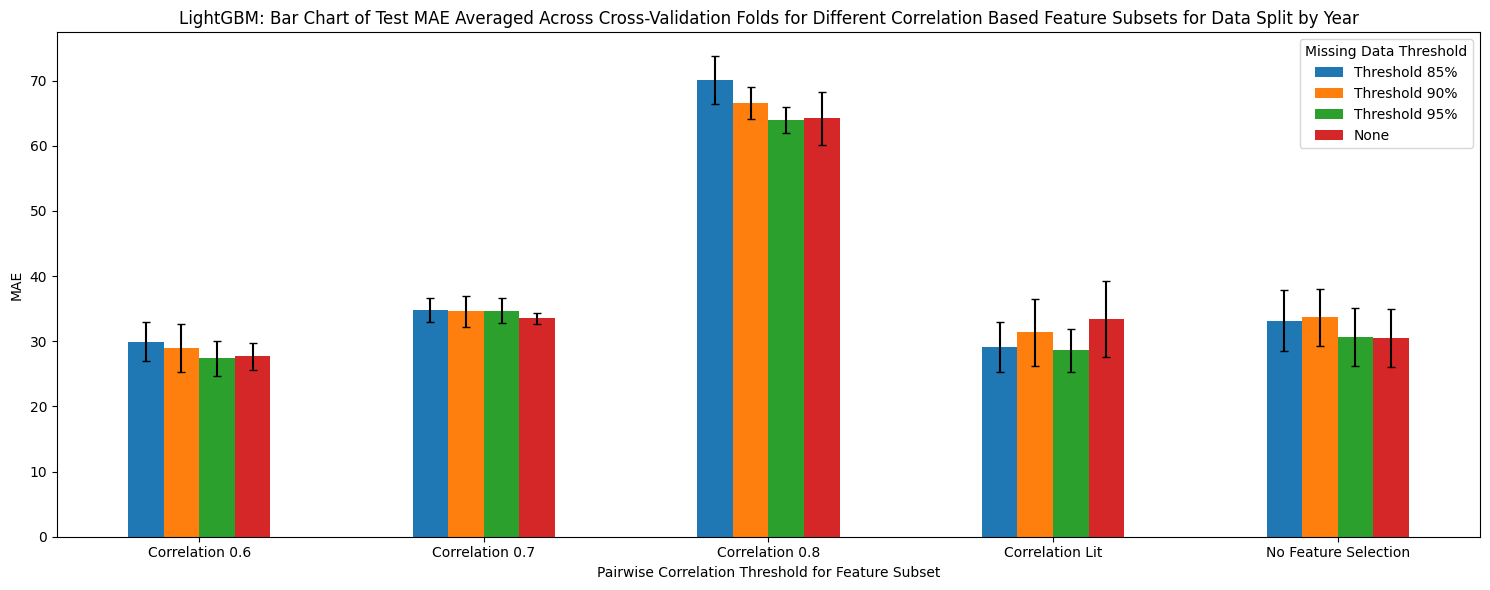

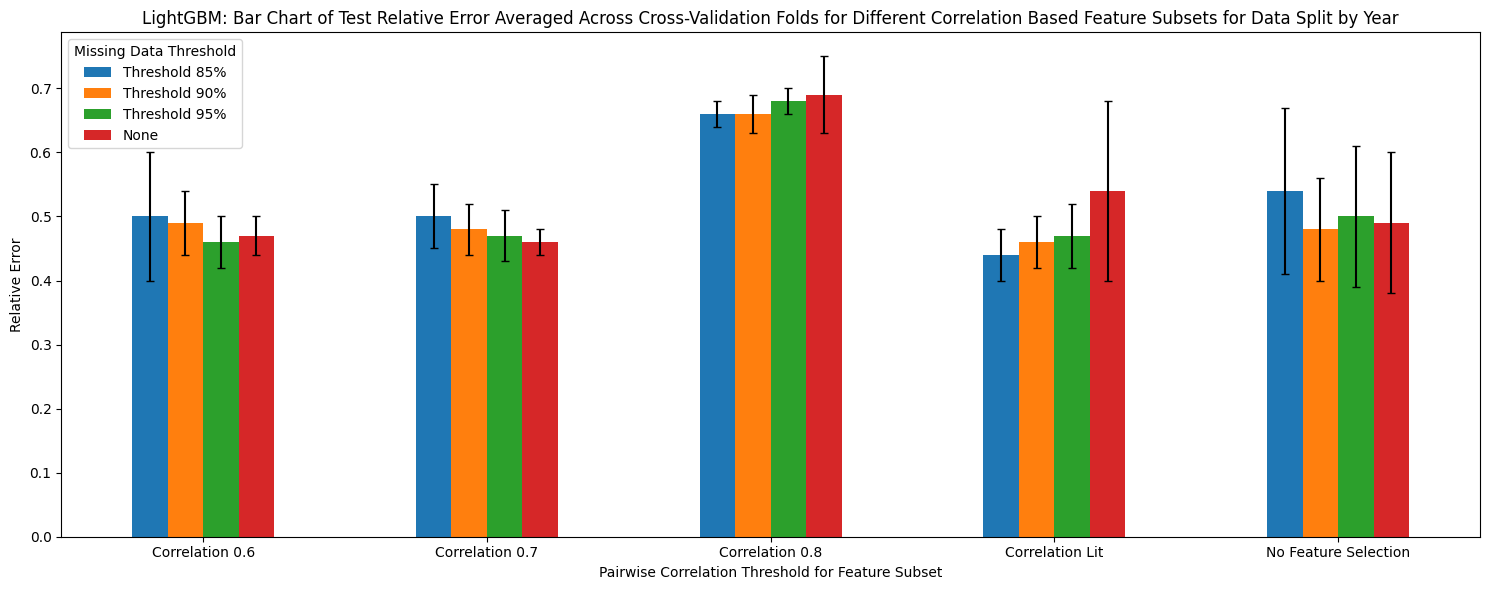

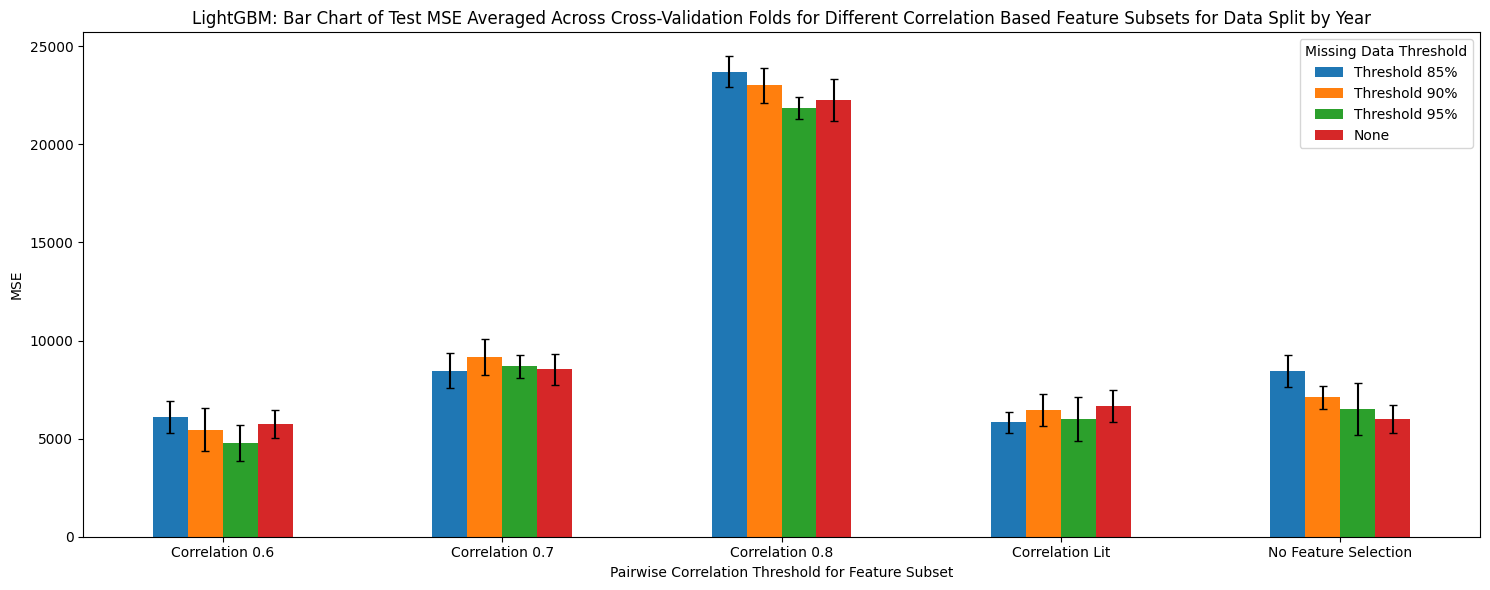

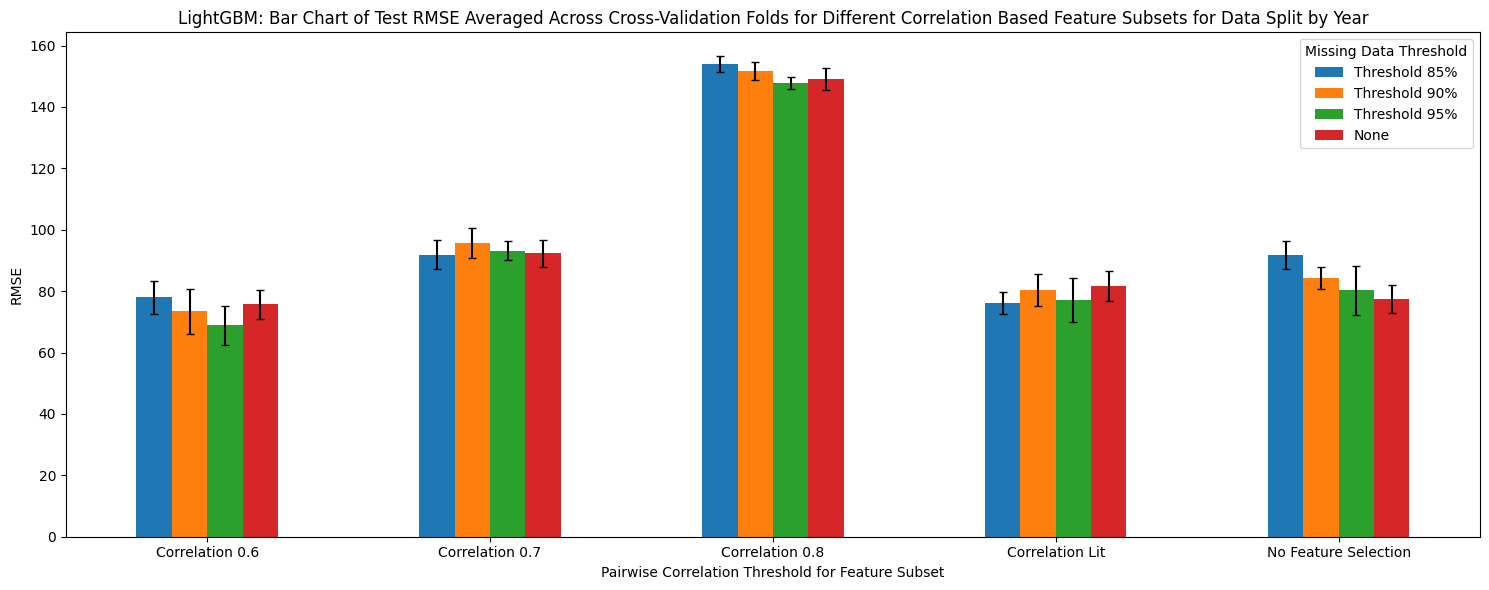

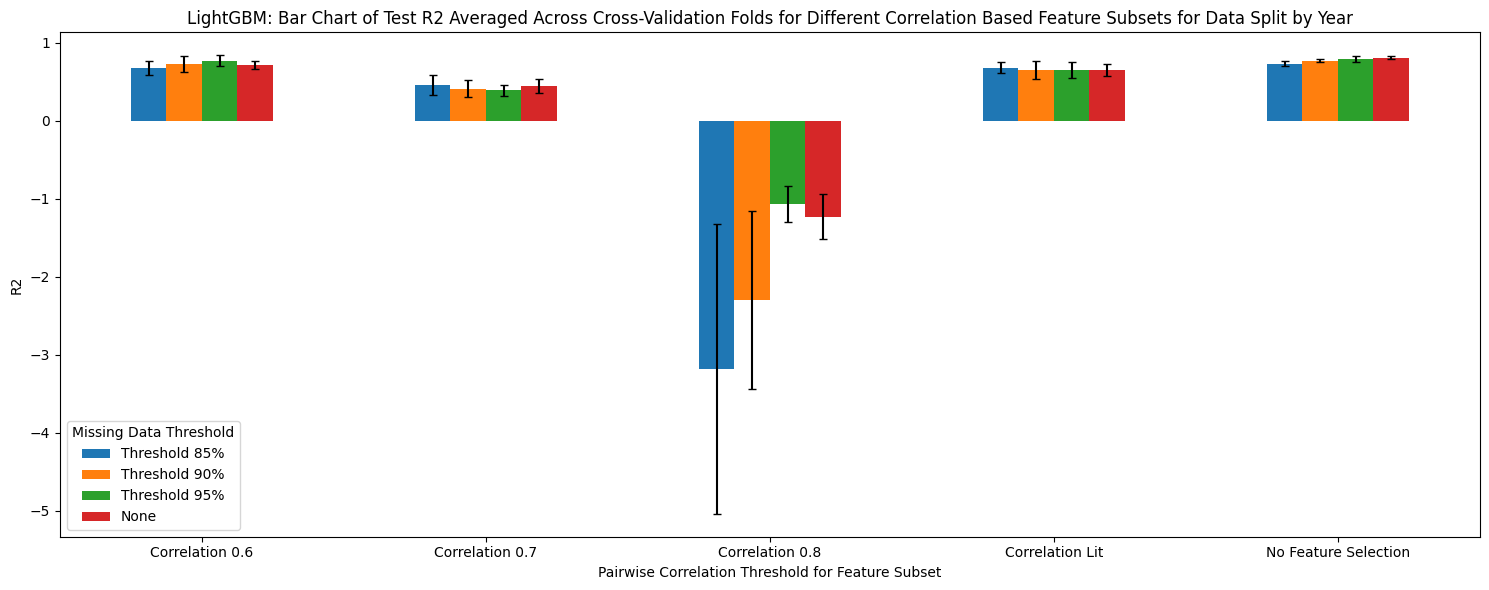

In [312]:
for metric in ['MAE', 'Relative Error', 'MSE', 'RMSE', 'R2']:
    mean_vals = mean_data_lgb_year[metric].unstack(level='Missing Data Threshold')
    std_vals = std_data_lgb_year[metric].unstack(level='Missing Data Threshold')
    mean_vals.plot.bar(yerr=std_vals, figsize=(15, 6), rot=0, capsize=3)
    plt.title("LightGBM: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds for Different Correlation Based Feature Subsets for Data Split by Year")
    plt.xlabel("Pairwise Correlation Threshold for Feature Subset")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

##### XGB

In [313]:
mean_data_xgb_year = all_data_xgb_year.astype(float)
std_data_xgb_year = all_std_data_xgb_year.astype(float)

new_order = ['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']
mean_data_xgb_year = all_data_xgb_year.astype(float)
std_data_xgb_year = all_std_data_xgb_year.astype(float)

mean_data_xgb_year.index = mean_data_xgb_year.index.set_levels(
    [mean_data_xgb_year.index.levels[0], pd.CategoricalIndex(mean_data_xgb_year.index.levels[1], categories=new_order, ordered=True)]
)

mean_data_xgb_year = mean_data_xgb_year.sort_index()

std_data_xgb_year.index = std_data_xgb_year.index.set_levels(
    [std_data_xgb_year.index.levels[0], pd.CategoricalIndex(std_data_xgb_year.index.levels[1], categories=new_order, ordered=True)]
)

std_data_xgb_year = std_data_xgb_year.sort_index()

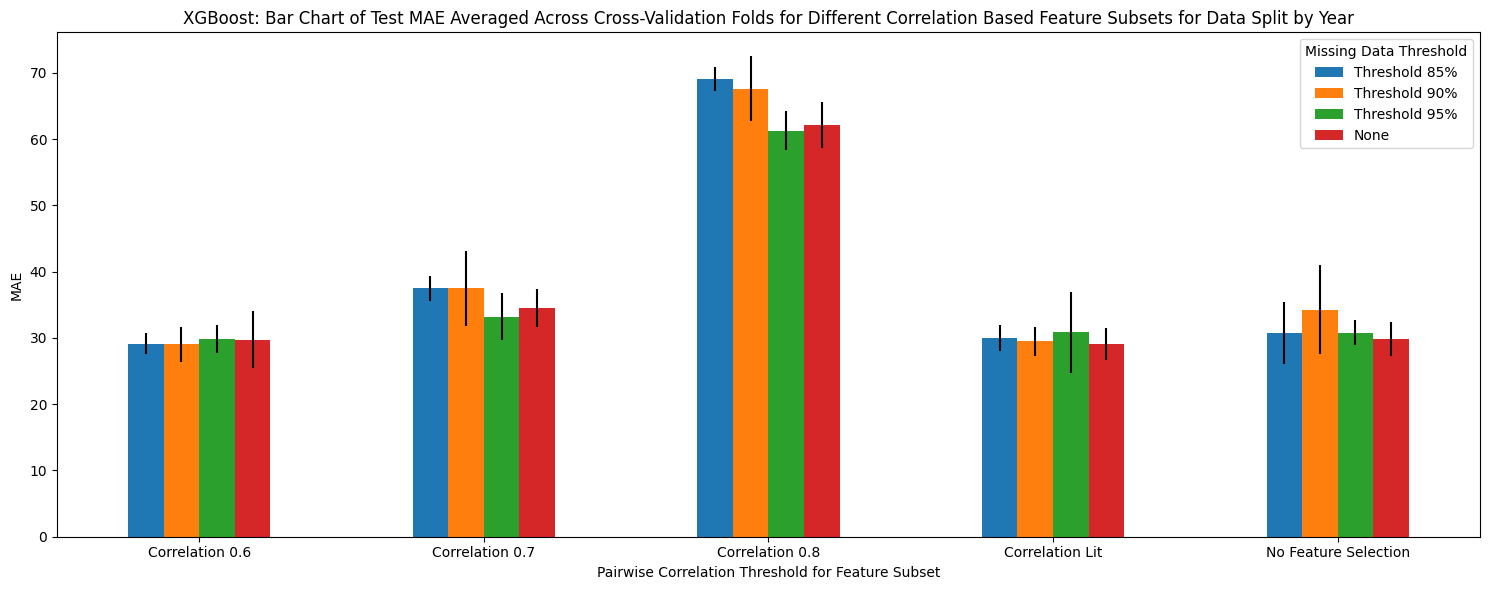

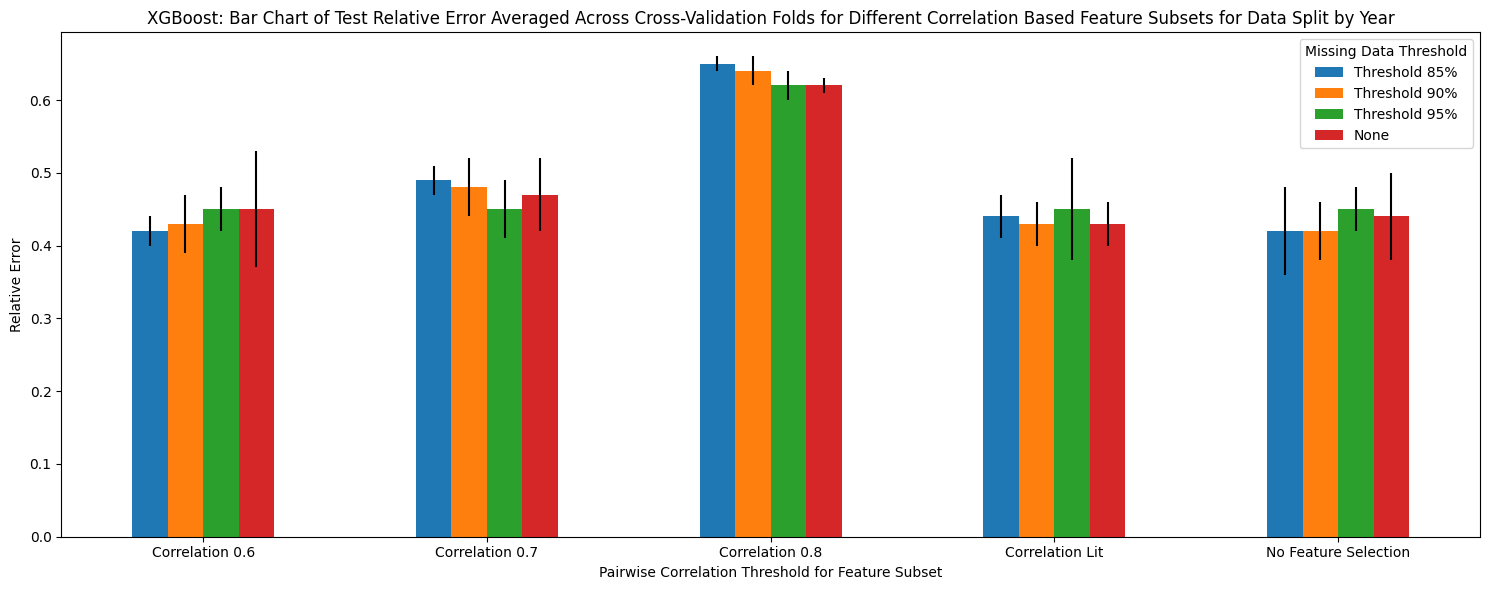

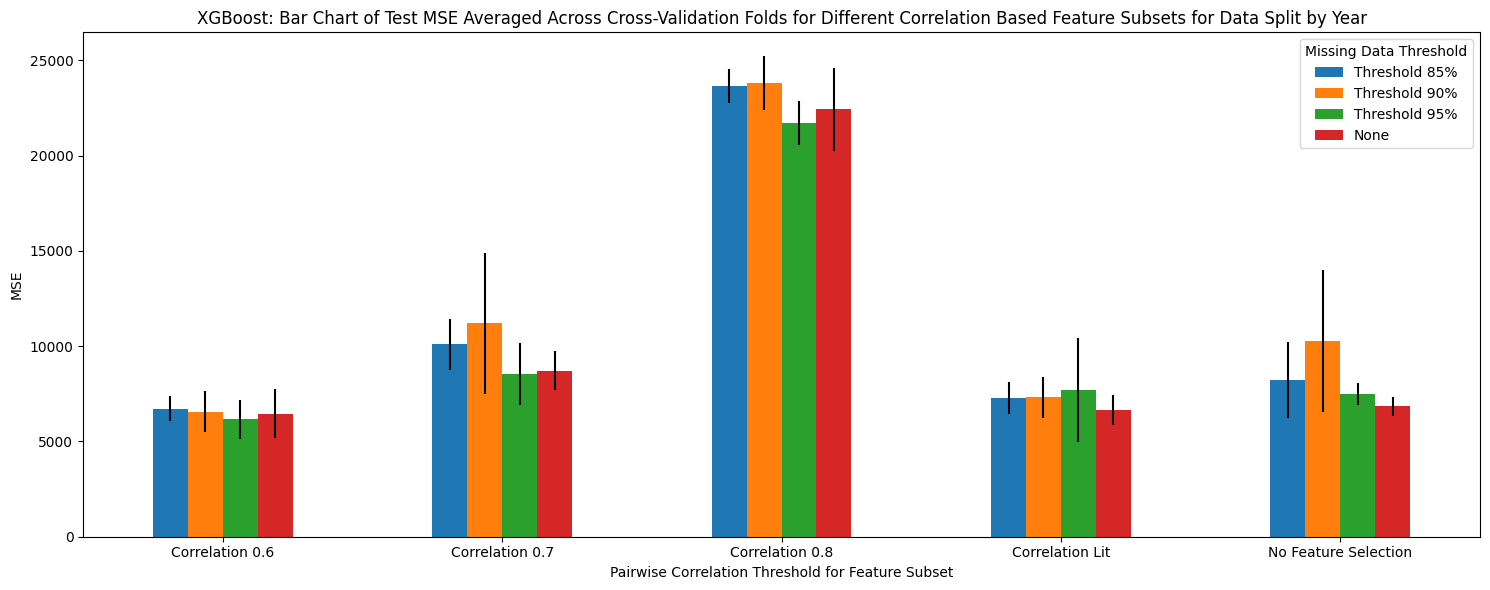

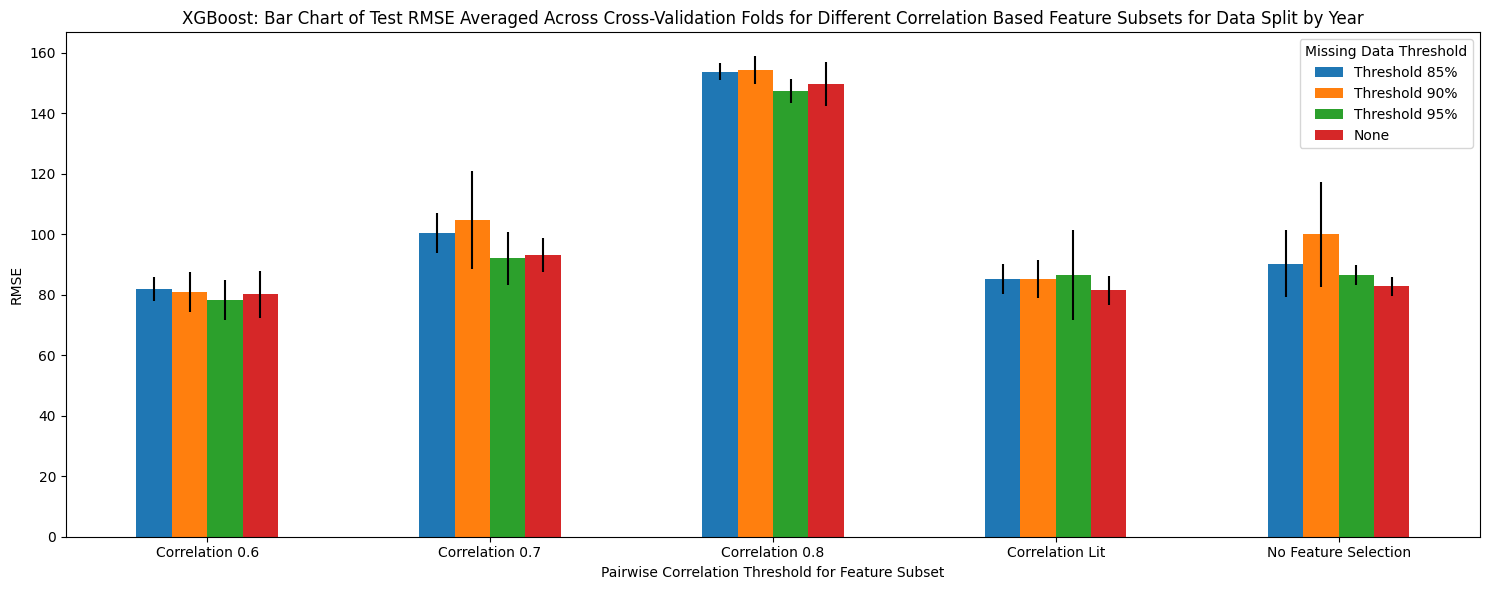

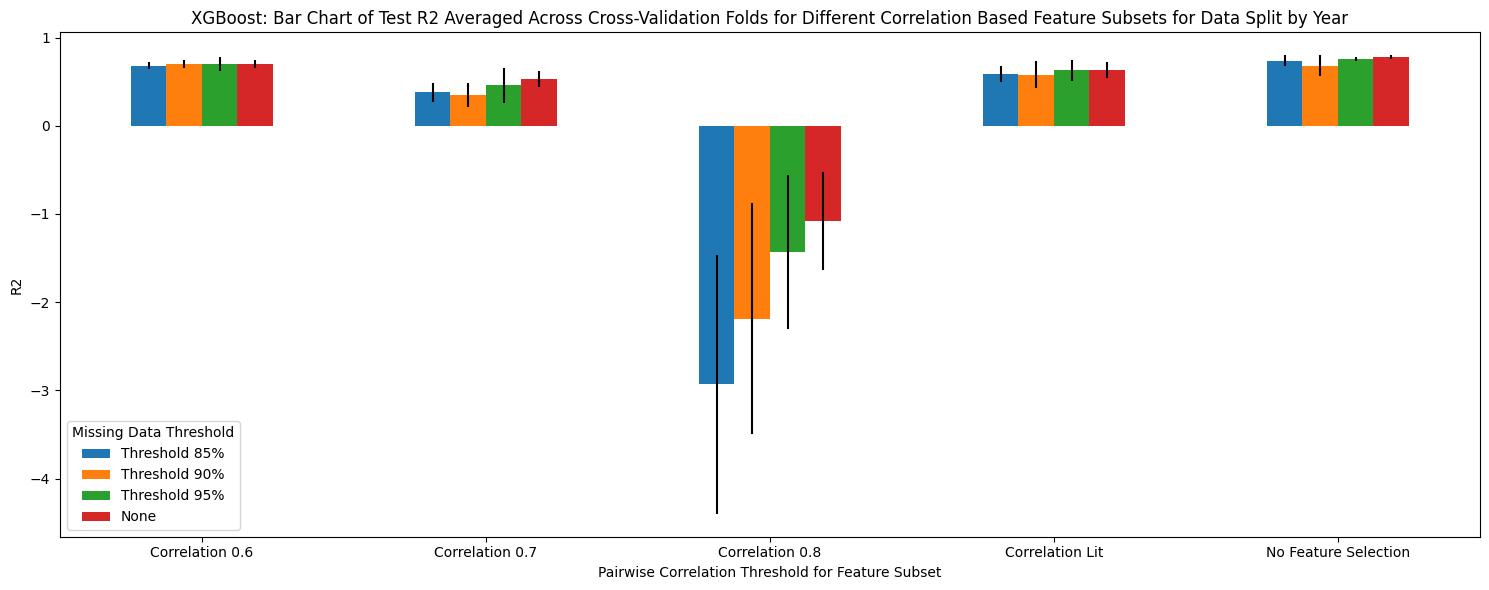

In [314]:
for metric in ['MAE', 'Relative Error', 'MSE', 'RMSE', 'R2']:
    mean_vals = mean_data_xgb_year[metric].unstack(level='Missing Data Threshold')
    std_vals = std_data_xgb_year[metric].unstack(level='Missing Data Threshold')
    mean_vals.plot.bar(yerr=std_vals, figsize=(15, 6), rot=0)
    plt.title("XGBoost: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds for Different Correlation Based Feature Subsets for Data Split by Year")
    plt.xlabel("Pairwise Correlation Threshold for Feature Subset")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

##### RF

In [2]:
mean_data_rf_year = all_data_rf_year.astype(float)
std_data_rf_year = all_std_data_rf_year.astype(float)

new_order = ['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']
mean_data_rf_year = all_data_rf_year.astype(float)
std_data_rf_year = all_std_data_rf_year.astype(float)

mean_data_rf_year.index = mean_data_rf_year.index.set_levels(
    [mean_data_rf_year.index.levels[0], pd.CategoricalIndex(mean_data_rf_year.index.levels[1], categories=new_order, ordered=True)]
)

mean_data_rf_year = mean_data_rf_year.sort_index()

std_data_rf_year.index = std_data_rf_year.index.set_levels(
    [std_data_rf_year.index.levels[0], pd.CategoricalIndex(std_data_rf_year.index.levels[1], categories=new_order, ordered=True)]
)

std_data_rf_year = std_data_rf_year.sort_index()

NameError: name 'all_data_rf_year' is not defined

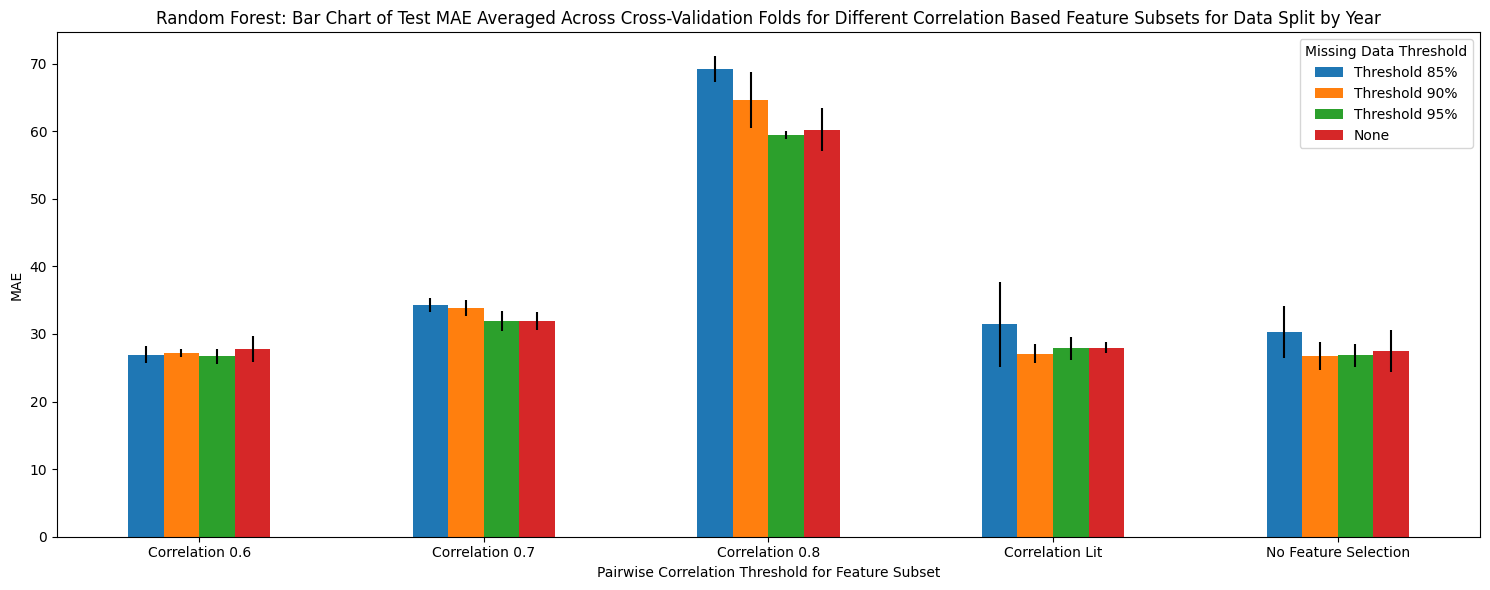

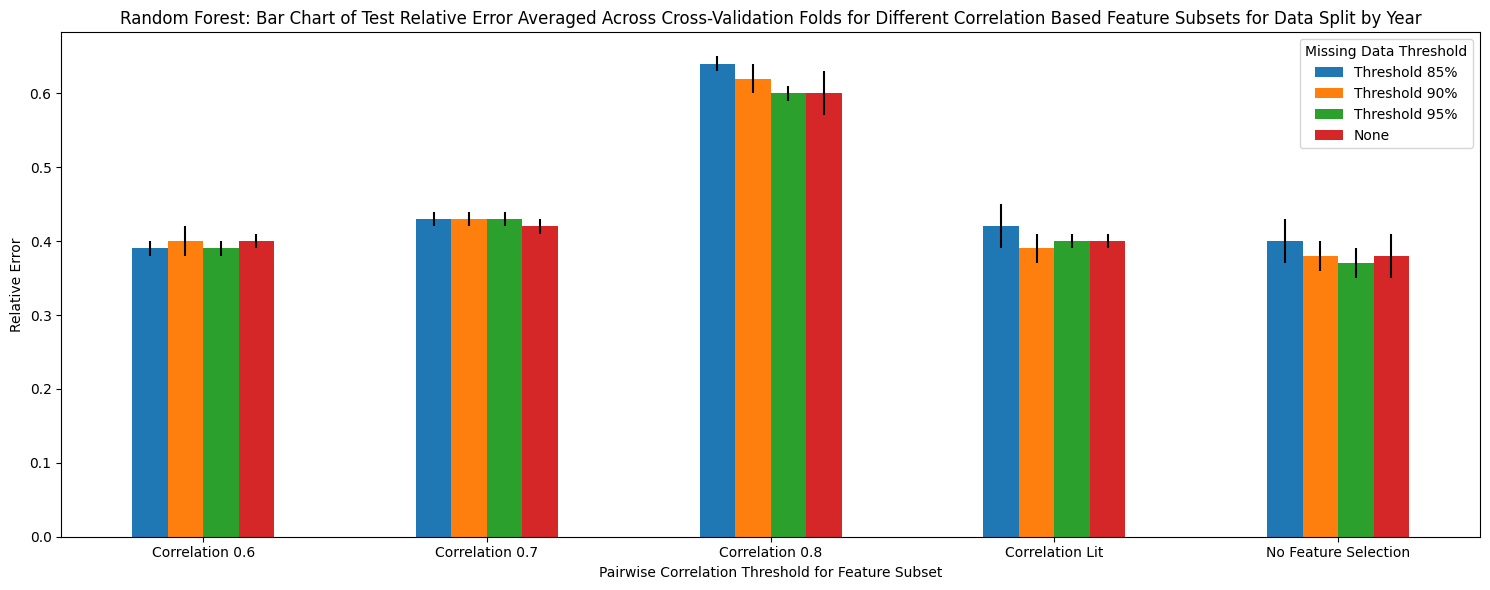

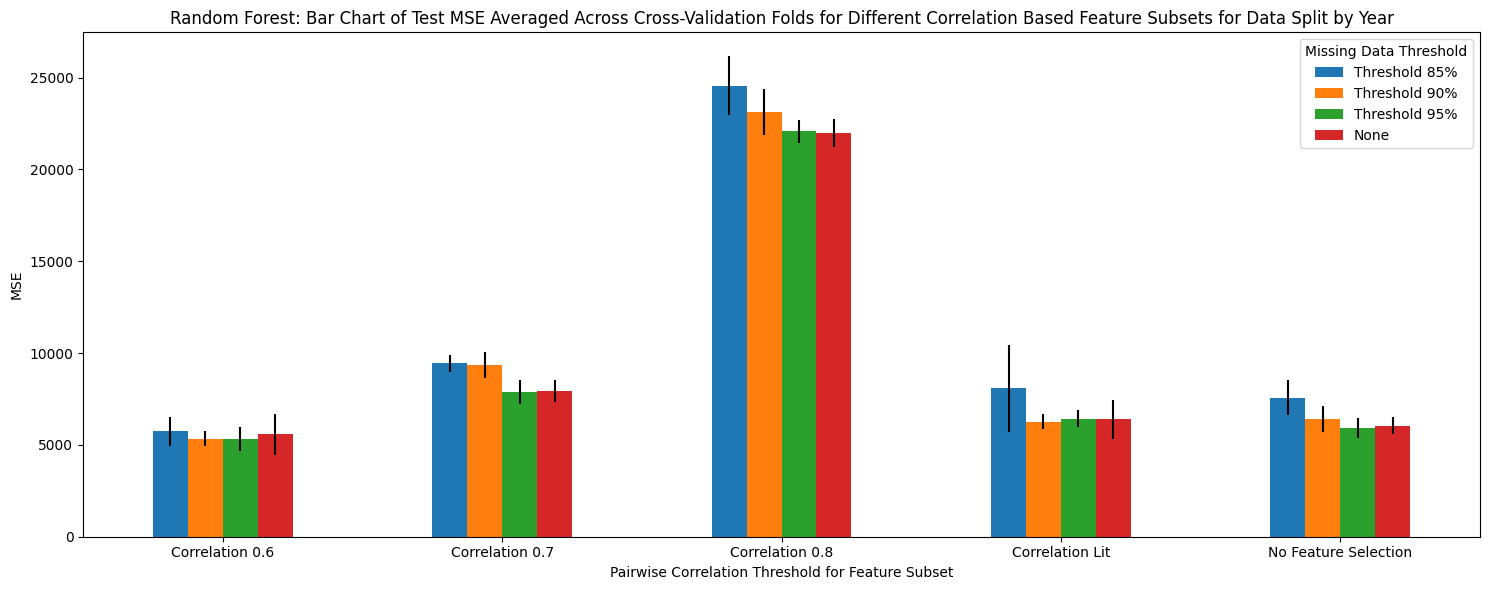

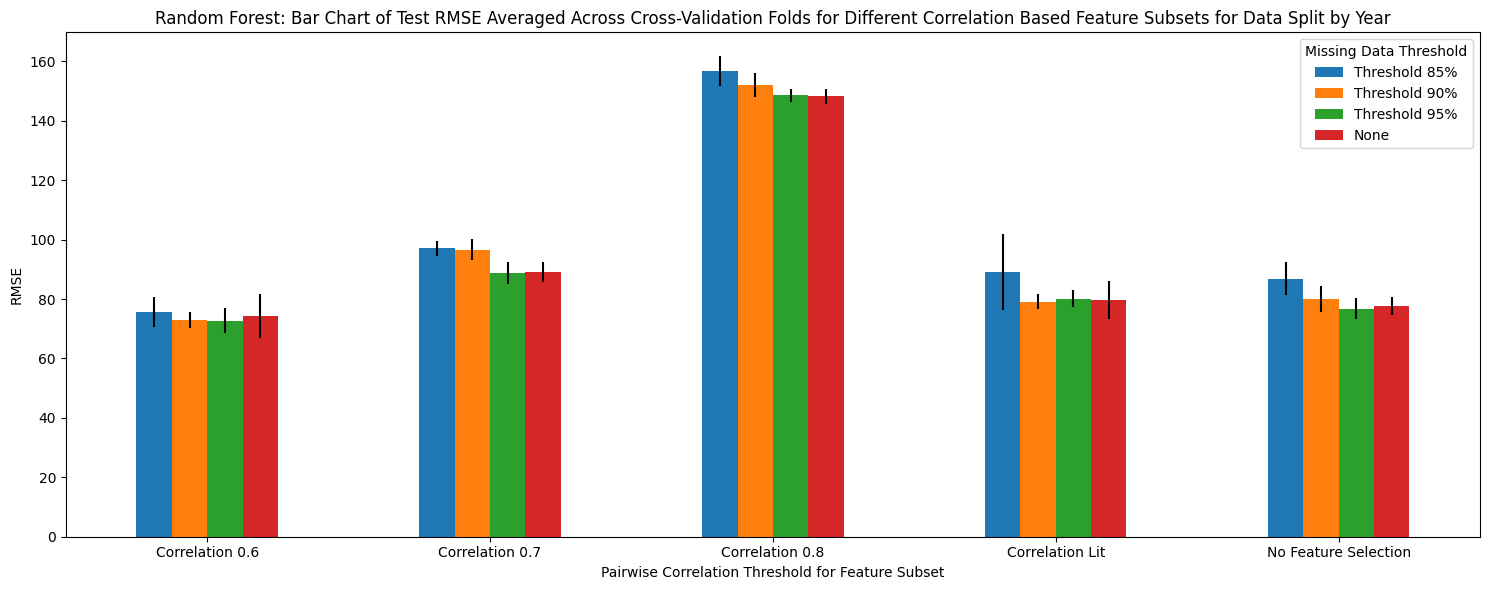

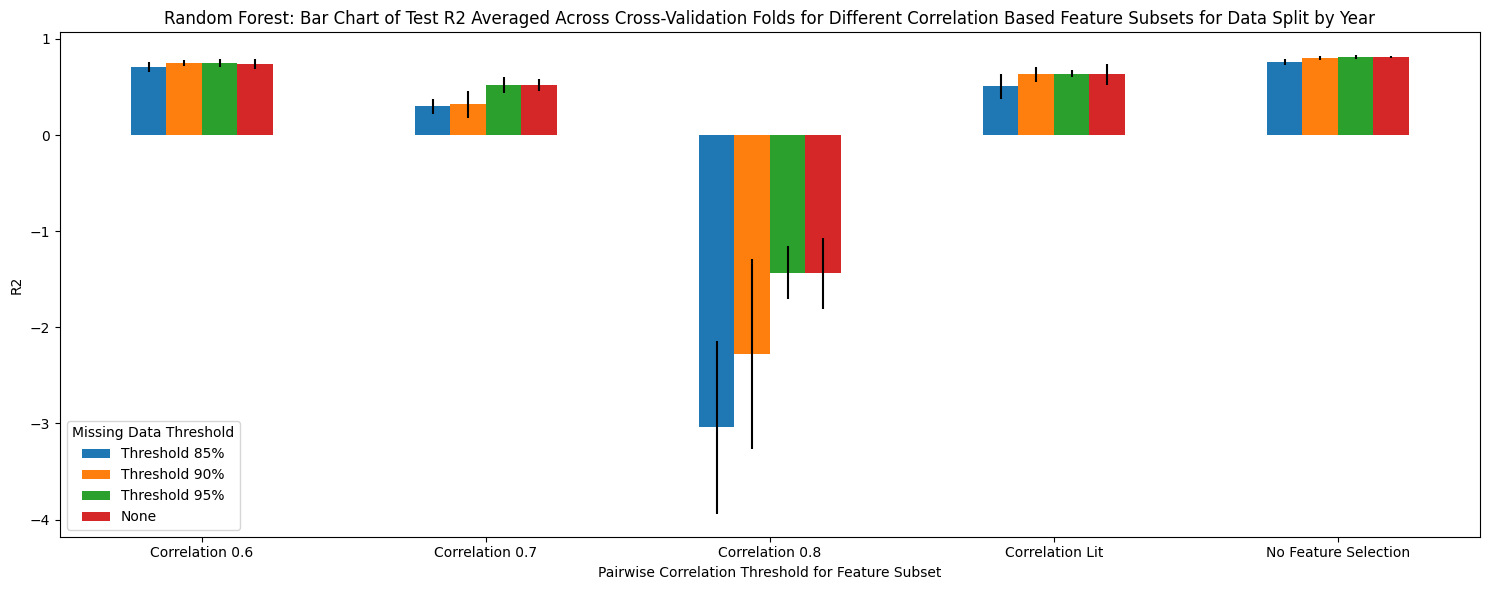

In [316]:
for metric in ['MAE', 'Relative Error', 'MSE', 'RMSE', 'R2']:
    mean_vals = mean_data_rf_year[metric].unstack(level='Missing Data Threshold')
    std_vals = std_data_rf_year[metric].unstack(level='Missing Data Threshold')
    mean_vals.plot.bar(yerr=std_vals, figsize=(15, 6), rot=0)
    plt.title("Random Forest: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds for Different Correlation Based Feature Subsets for Data Split by Year")
    plt.xlabel("Pairwise Correlation Threshold for Feature Subset")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()